(ordinal_regression)=
# Regression Models with Ordered Categorical Outcomes

:::{post} April, 2023
:tags: ordinal regression, generalized linear model, 
:category: beginner, reference
:author: Nathaniel Forde
:::

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import statsmodels.api as sm

from scipy.stats import bernoulli
from statsmodels.miscmodels.ordinal_model import OrderedModel

In [2]:
%config InlineBackend.figure_format = 'retina'  # high resolution figures
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(42)

## Ordered Categories: Known Distribution

We'll start by generating some fake data. Imagine an employee/manager relationship where part of the annual process involves conducting a 360 degree review. The manager gets a rating (1 - 10) by their team and HR collects these ratings. The HR manager wants to know which factors influence the manager's rating and what can move a manager who receives a 4 into a 5 or a 7 into an 8. They have a theory that the rating is largely a function of salary. 

Ordinal Regression is a statistical technique designed to model these kinds of relationships. 

In [3]:
def make_data():
    salary = np.random.normal(40, 10, 500)
    work_sat = np.random.beta(1, 0.4, 500)
    work_from_home = bernoulli.rvs(0.7, size=500)
    work_from_home_calc = np.where(work_from_home, 1.4 * work_from_home, work_from_home)
    latent_rating = (
        0.08423 * salary + 0.2 * work_sat + work_from_home_calc + np.random.normal(0, 1, 500)
    )
    explicit_rating = np.round(latent_rating, 0)
    df = pd.DataFrame(
        {
            "salary": salary,
            "work_sat": work_sat,
            "work_from_home": work_from_home,
            "latent_rating": latent_rating,
            "explicit_rating": explicit_rating,
        }
    )
    return df


try:
    df = pd.read_csv("../data/fake_employee_manger_rating.csv")
except FileNotFoundError:
    df = make_data()

K = len(df["explicit_rating"].unique())
df.head()

,Unnamed: 0,salary,work_sat,work_from_home,latent_rating,explicit_rating
0,0,41.172474,0.632002,1,5.328188,5.0
1,1,40.984524,0.904452,0,3.198263,3.0
2,2,36.469472,0.911330,1,4.108042,4.0
3,3,6.453822,0.919106,0,1.496440,1.0
4,4,33.795497,0.894581,0,3.200672,3.0


We've specified our data in such a way that there is an underlying latent sentiment which is continuous in scale that gets crudely discretised to represent the ordinal rating scale. We've specified the data in such a way that salary drives a fairly linear increase in the manager's rating. 

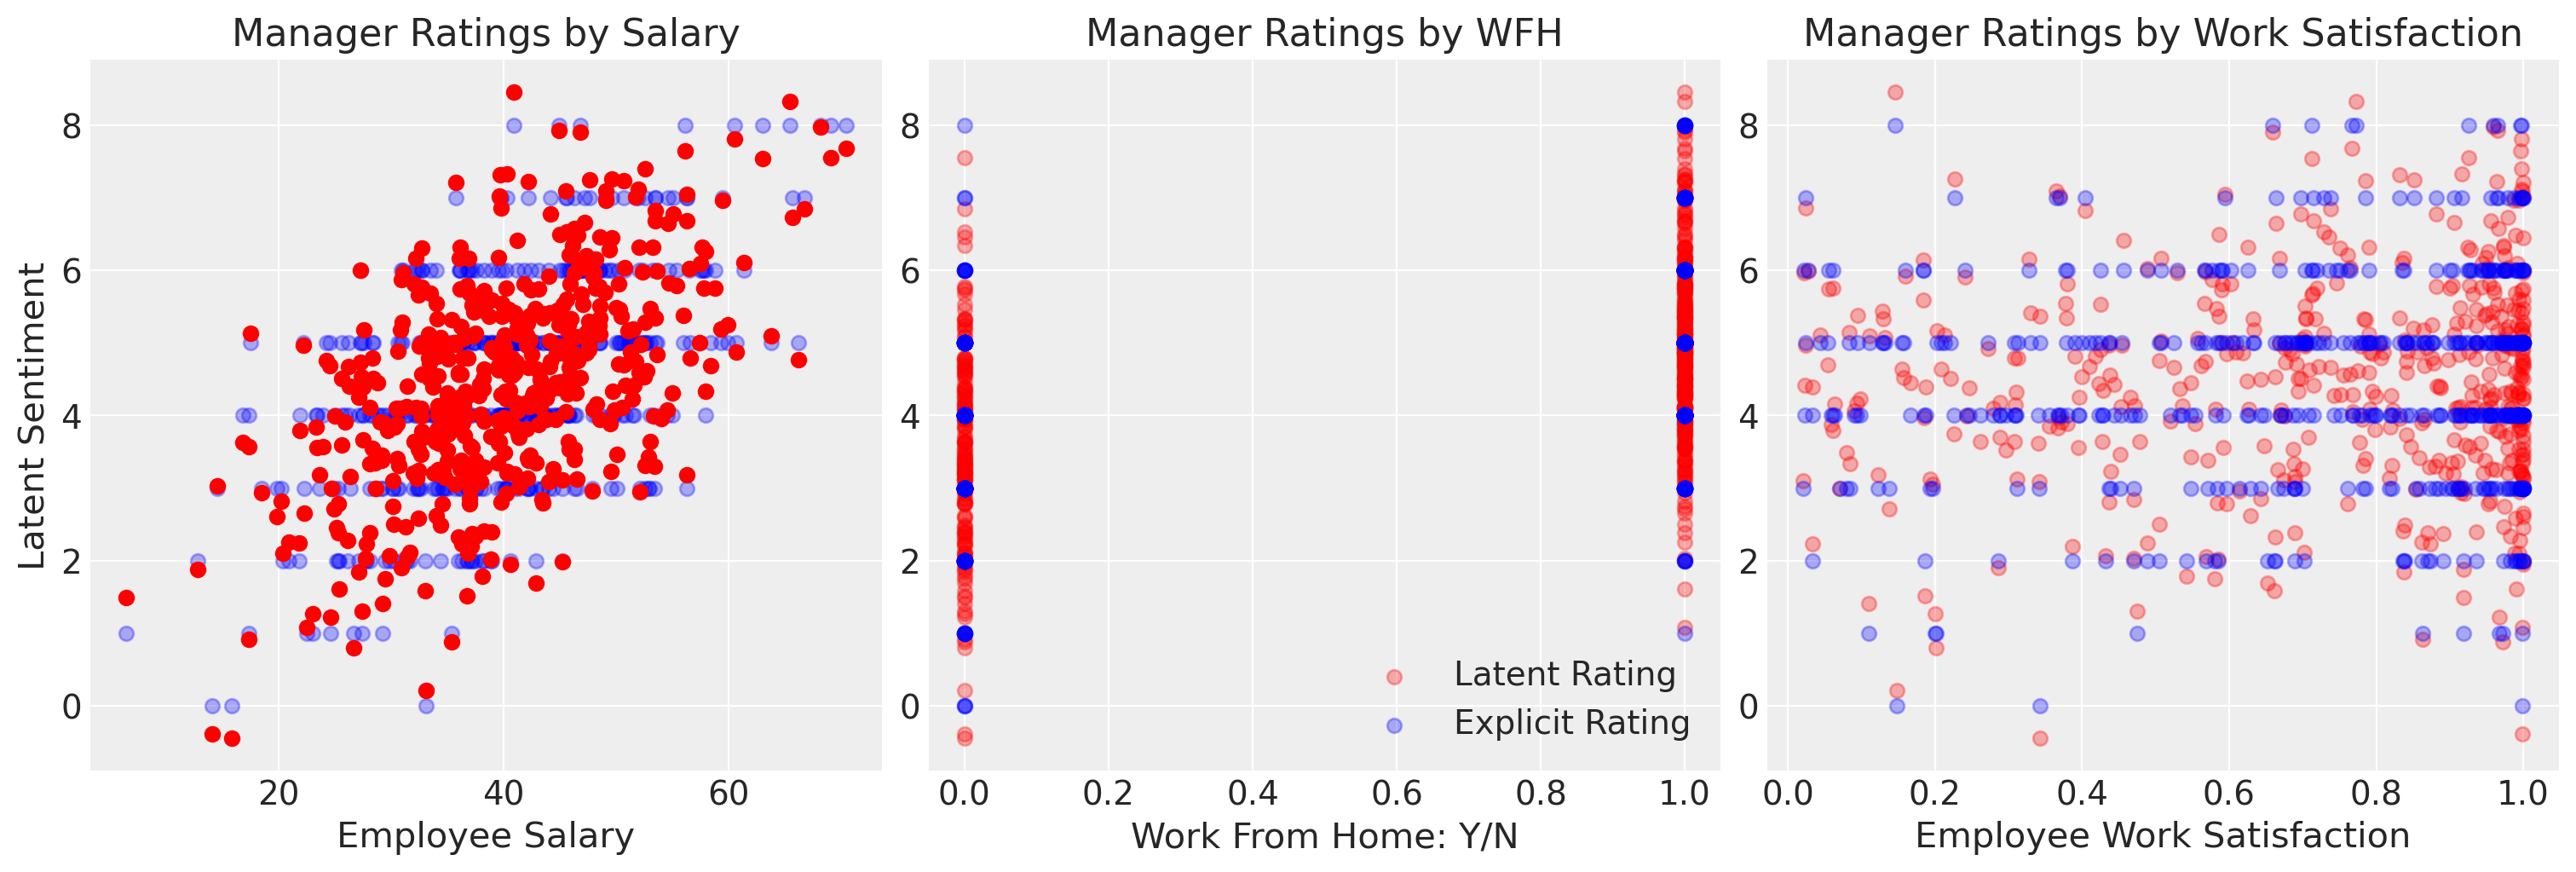

In [4]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs = axs.flatten()
ax = axs[0]
ax.scatter(df["salary"], df["explicit_rating"], label="Explicit Rating", color="blue", alpha=0.3)
axs[1].scatter(
    df["work_from_home"], df["latent_rating"], label="Latent Rating", color="red", alpha=0.3
)
axs[1].scatter(
    df["work_from_home"], df["explicit_rating"], label="Explicit Rating", c="blue", alpha=0.3
)
axs[2].scatter(df["work_sat"], df["latent_rating"], label="Latent Rating", color="red", alpha=0.3)
axs[2].scatter(
    df["work_sat"], df["explicit_rating"], label="Explicit Rating", color="blue", alpha=0.3
)
ax.scatter(df["salary"], df["latent_rating"], label="Latent Sentiment", color="red")
ax.set_title("Manager Ratings by Salary")
axs[1].set_title("Manager Ratings by WFH")
axs[2].set_title("Manager Ratings by Work Satisfaction")
ax.set_ylabel("Latent Sentiment")
ax.set_xlabel("Employee Salary")
axs[1].set_xlabel("Work From Home: Y/N")
axs[2].set_xlabel("Employee Work Satisfaction")
axs[1].legend();

We can see here however that if we fit this model with a simple OLS fit it implies values beyond the categorical scale, which might motivate spurious salary increases by an overzealous HR manager. The OLS approximation is limited in that it cannot account for the proper nature of the outcome variable. 

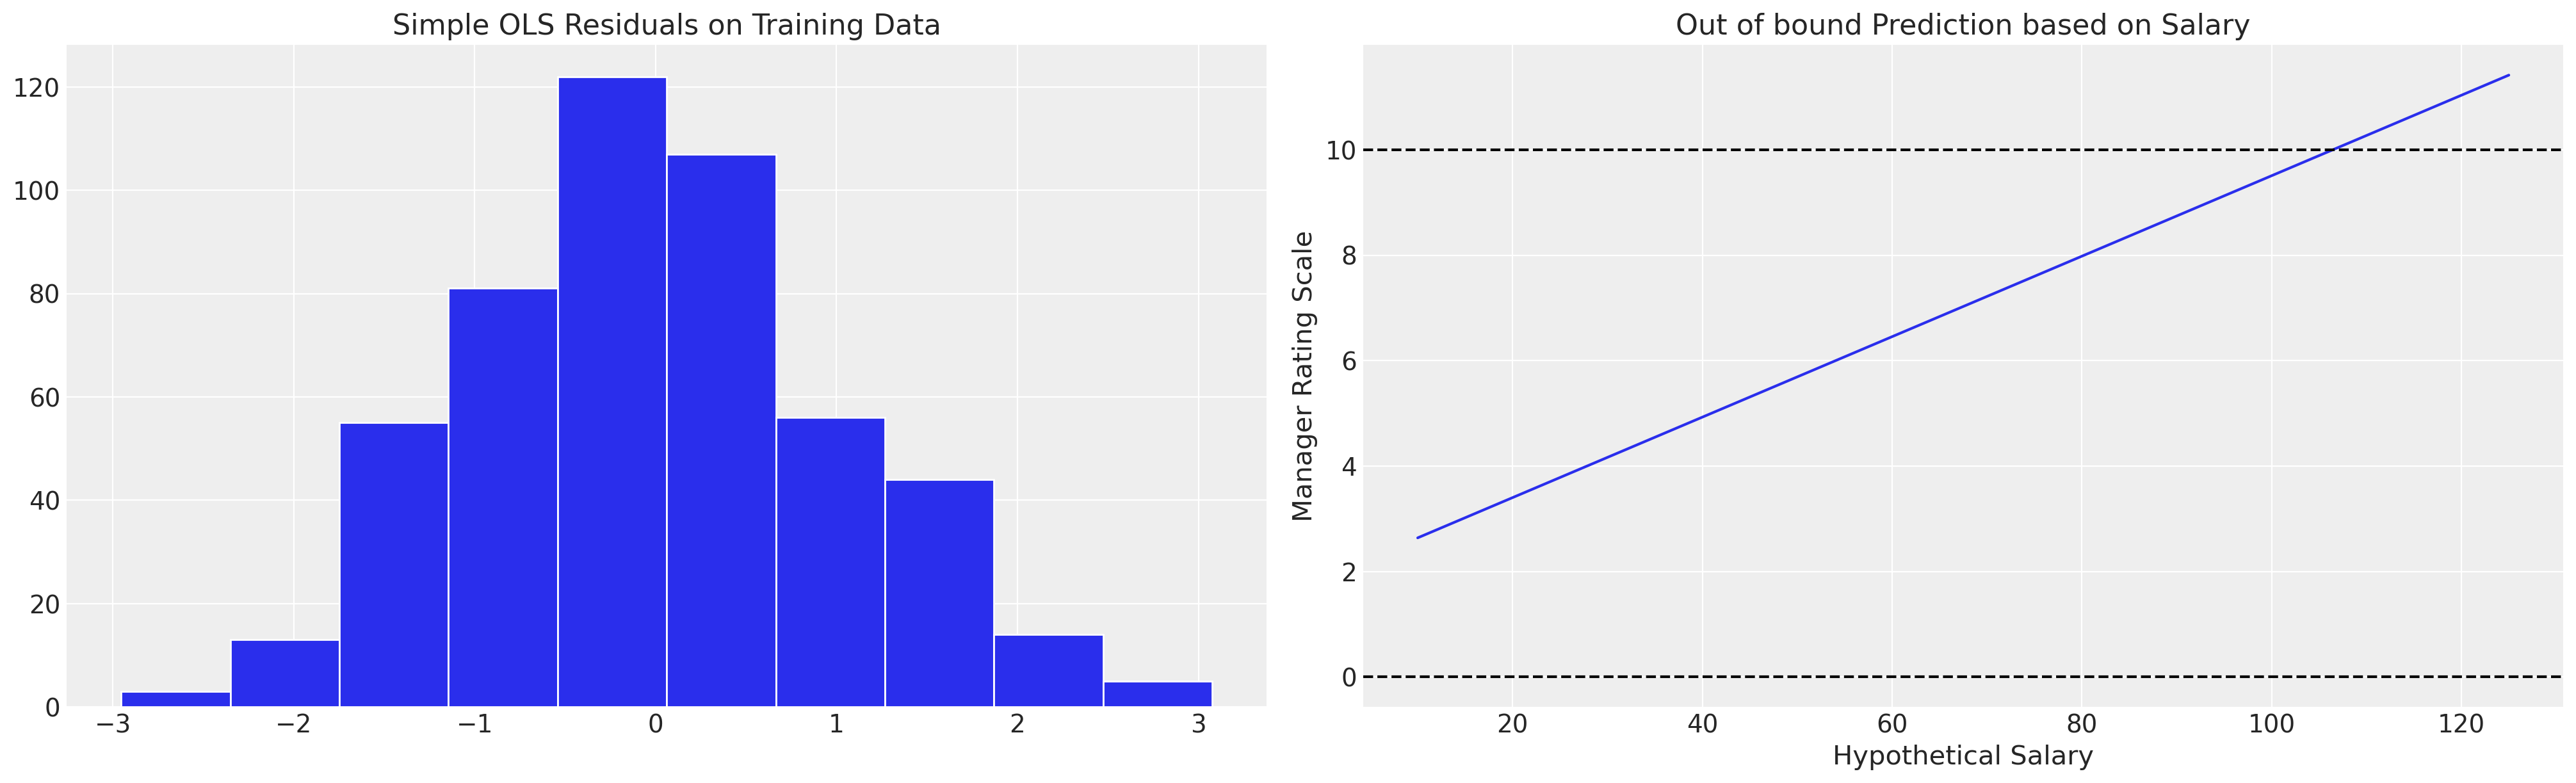

In [5]:
exog = sm.add_constant(df[["salary", "work_from_home", "work_sat"]])
mod = sm.OLS(df["explicit_rating"], exog)
results = mod.fit()
results.summary()

results.predict([1, 200, 1, 0.6])
fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs = axs.flatten()
ax = axs[1]
salaries = np.linspace(10, 125, 20)
predictions = [results.predict([1, i, 1, 0.6])[0] for i in salaries]
ax.plot(salaries, predictions, label="Implied Linear function of Salaries on Outcome")
ax.set_title("Out of bound Prediction based on Salary")
ax.axhline(10, linestyle="--", color="black")
ax.set_xlabel("Hypothetical Salary")
ax.set_ylabel("Manager Rating Scale")
ax.axhline(0, linestyle="--", color="black")
axs[0].hist(results.resid, ec="white")
axs[0].set_title("Simple OLS Residuals on Training Data");

## Ordinal Regression Models: The Idea

In this notebook we'll show how to fit regression models to outcomes with ordered categories. These types of models can be considered as an application logistic regression models with multiple thresholds on a latent continuous scale. This is quite a natural perspective e.g. imagine the bundling of complexity that gets hidden in crude political classifications: liberal, moderate and conservative. You may have a range of views on any number of political issues, but they all get collapsed in the political calculus to finite set of (generally poor) choices. Which of the last 10 political choices pushed you from liberal to moderate?


The idea is to treat the outcome variable (our categorical) judgment as deriving from an underlying continuous measure. We see the outcomes we do just when some threshold on that continuous measure has been achieved. The primary inferential task of ordinal regression is to derive an estimate of those thresholds in the latent continuous space. 

In the data set above we've explicitly specified the relationship, and in the following steps we'll estimate a variety of ordinal regression models.


## Fit a variety of Model Specifications

The model specification for ordinal regression models typically makes use of the the logit transformation and the cumulative probabilities implied. For $c$ outcome categories with probabilities $\pi_1, .... \pi_n$ the *cumulative logits* are defined:

$$ logit[P(Y \leq j)]  = log \frac{P(Y \leq j)}{1 - p(Y \leq j)}  = log \frac{\pi_1 + ... + \pi_j}{\pi_{j+1} + ... + \pi_n} \text{ where  j = 1, ..., c-1} $$

This gets employed in a regression context where we specify the factors which determine our latent outcome in a linear fashion:

$$ logit[P(Y \leq j)] = \alpha_{j} + \beta'x $$

which implies that:

$$ P(Y \leq j) = \frac{exp(\alpha_{j} + \beta'x)}{1 + exp(\alpha_{j} + \beta'x)} $$

and that the probability for belonging within a particular category $j$ is determined by the probability of being in the cell defined by: 

$$ P(Y = j) = \frac{exp(\alpha_{j} + \beta'x)}{1 + exp(\alpha_{j} + \beta'x)} - \frac{exp(\alpha_{j-1} + \beta'x)}{1 + exp(\alpha_{j-1} + \beta'x)} $$

One nice feature of ordinal regressions specified in this fashion is that the interpretation of the coefficients on the beta terms remain the same across each interval on the latent space. The interpretaiton of the model parameters is typical: a unit increase in $x_{k}$ corresponds to an increase in $Y_{latent}$ of $\beta_{k}$ Similar interpretation holds for probit regression specification too. 

### Bayesian Particularities 

While Ordinal regression is often performed in a frequentist paradigm, the same techniques can be applied in a Bayesian setting with all the benefits of posterior probability distributions and posterior predictive simulations. In PyMC there are at least two ways we can go about specifying the priors over the this model. The first one uses a constrained Dirichlet distribution to define a prior over the thresholds. The second method, a little looser allows the specification of any prior distribution with suitable number of cutpoints applying a ordering transformation on the generated samples from the prior distribution. 

We'll show both in this notebook, but as we'll see, the definition of the Dirchlet ensures properties which make it a better fit for the constrained outcome space. In each approach we can include covariates as in more standard regression models. 

PyMC has both `OrderedLogistic` and `OrderedProbit` distributions available. 

In [6]:
def constrainedUniform(N, min=0, max=1):
    return pm.Deterministic(
        "cutpoints",
        pt.concatenate(
            [
                np.ones(1) * min,
                pt.extra_ops.cumsum(pm.Dirichlet("cuts_unknown", a=np.ones(N - 2)))
                * (min + (max - min)),
            ]
        ),
    )

The above function, (brainchild of Dr Ben Vincent), looks a little indimidating, but it's just a convenience function to specify a prior over the cutpoints in our $Y_{latent}$. The Dirichlet distribution is special in that draws from the distribution must sum to one. The above function ensures that each draw from the prior distribution is a cumulative share of the maximum category greater than the minimum of our ordinal categorisation. 

In [7]:
def make_model(priors, model_spec=1, constrained_uniform=False, logit=True):
    with pm.Model() as model:

        if constrained_uniform:
            cutpoints = constrainedUniform(K, 0, K)
        else:
            sigma = pm.Exponential("sigma", priors["sigma"])
            cutpoints = pm.Normal(
                "cutpoints",
                mu=priors["mu"],
                sigma=sigma,
                transform=pm.distributions.transforms.univariate_ordered,
            )

        if model_spec == 1:
            beta = pm.Normal("beta", priors["beta"][0], priors["beta"][1], size=1)
            mu = pm.Deterministic("mu", beta[0] * df.salary)
        elif model_spec == 2:
            beta = pm.Normal("beta", priors["beta"][0], priors["beta"][1], size=2)
            mu = pm.Deterministic("mu", beta[0] * df.salary + beta[1] * df.work_sat)
        elif model_spec == 3:
            beta = pm.Normal("beta", priors["beta"][0], priors["beta"][1], size=3)
            mu = pm.Deterministic(
                "mu", beta[0] * df.salary + beta[1] * df.work_sat + beta[2] * df.work_from_home
            )
        if logit:
            y_ = pm.OrderedLogistic("y", cutpoints=cutpoints, eta=mu, observed=df.explicit_rating)
        else:
            y_ = pm.OrderedProbit("y", cutpoints=cutpoints, eta=mu, observed=df.explicit_rating)
        idata = pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True})
        idata.extend(pm.sample_posterior_predictive(idata))
    return idata, model


priors = {"sigma": 1, "beta": [0, 1], "mu": np.linspace(0, K, K - 1)}
idata1, model1 = make_model(priors, model_spec=1)
idata2, model2 = make_model(priors, model_spec=2)
idata3, model3 = make_model(priors, model_spec=3)
idata4, model4 = make_model(priors, model_spec=3, constrained_uniform=True)
idata5, model5 = make_model(priors, model_spec=3, constrained_uniform=True)

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.11/site-packages/pymc/sampling/mcmc.py:242: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.705757
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.900399
Transforming variables...
Transformation time =  0:00:00.395874
Computing Log Likelihood...


Sampling: [y]


Log Likelihood time =  0:00:00.553101


/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.11/site-packages/pymc/sampling/mcmc.py:242: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.064004
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:05.188302
Transforming variables...
Transformation time =  0:00:00.211913
Computing Log Likelihood...


Sampling: [y]


Log Likelihood time =  0:00:00.332566


/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.11/site-packages/pymc/sampling/mcmc.py:242: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.186262
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:05.987113
Transforming variables...
Transformation time =  0:00:00.158121
Computing Log Likelihood...


Sampling: [y]


Log Likelihood time =  0:00:00.309086


/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.11/site-packages/pymc/sampling/mcmc.py:242: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.972462
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:04.145298
Transforming variables...
Transformation time =  0:00:00.304025
Computing Log Likelihood...


Sampling: [y]


Log Likelihood time =  0:00:00.322300


/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.11/site-packages/pymc/sampling/mcmc.py:242: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.721487
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.902763
Transforming variables...
Transformation time =  0:00:00.313461
Computing Log Likelihood...


Sampling: [y]


Log Likelihood time =  0:00:00.321892


In [8]:
az.summary(idata3, var_names=["sigma", "cutpoints", "beta"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sigma,2.053,0.623,1.032,3.233,0.012,0.008,2570.0,2546.0,1.0
cutpoints[0],-1.675,0.801,-3.145,-0.158,0.016,0.012,2522.0,2309.0,1.0
cutpoints[1],1.256,0.493,0.359,2.215,0.008,0.006,4019.0,3161.0,1.0
cutpoints[2],3.395,0.453,2.550,4.237,0.008,0.006,3381.0,3387.0,1.0
cutpoints[3],5.075,0.472,4.171,5.919,0.009,0.006,2937.0,3117.0,1.0
cutpoints[4],6.887,0.514,5.965,7.852,0.010,0.007,2788.0,2939.0,1.0
cutpoints[5],8.764,0.562,7.703,9.776,0.011,0.008,2633.0,2903.0,1.0
cutpoints[6],10.343,0.613,9.252,11.506,0.012,0.008,2615.0,2327.0,1.0
cutpoints[7],12.317,0.730,11.052,13.769,0.014,0.010,2800.0,2940.0,1.0
beta[0],0.130,0.010,0.111,0.149,0.000,0.000,3332.0,3082.0,1.0


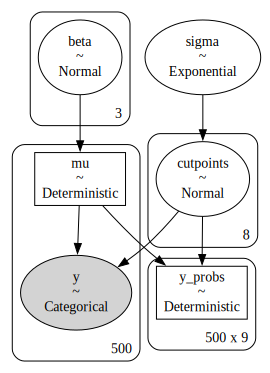

In [9]:
pm.model_to_graphviz(model3)

### Extracting the Probabilities 

We can now for each individual manager's rating, look at the probability associated with each of the available categories. Across the posterior distributions of our cuts which section of the latent continous measure the employee is most likely to fall into.

In [10]:
implied_probs = az.extract(idata3, var_names=["y_probs"])
implied_probs.shape

(500, 9, 4000)

In [11]:
implied_probs[0].mean(axis=1)

<xarray.DataArray 'y_probs' (y_probs_dim_1: 9)>
array([1.07497884e-04, 1.45741130e-03, 1.09266504e-02, 5.01274495e-02,
       2.25677139e-01, 4.35885233e-01, 2.02203397e-01, 6.21309983e-02,
       1.14842233e-02])
Coordinates:
    y_probs_dim_0  int64 0
  * y_probs_dim_1  (y_probs_dim_1) int64 0 1 2 3 4 5 6 7 8

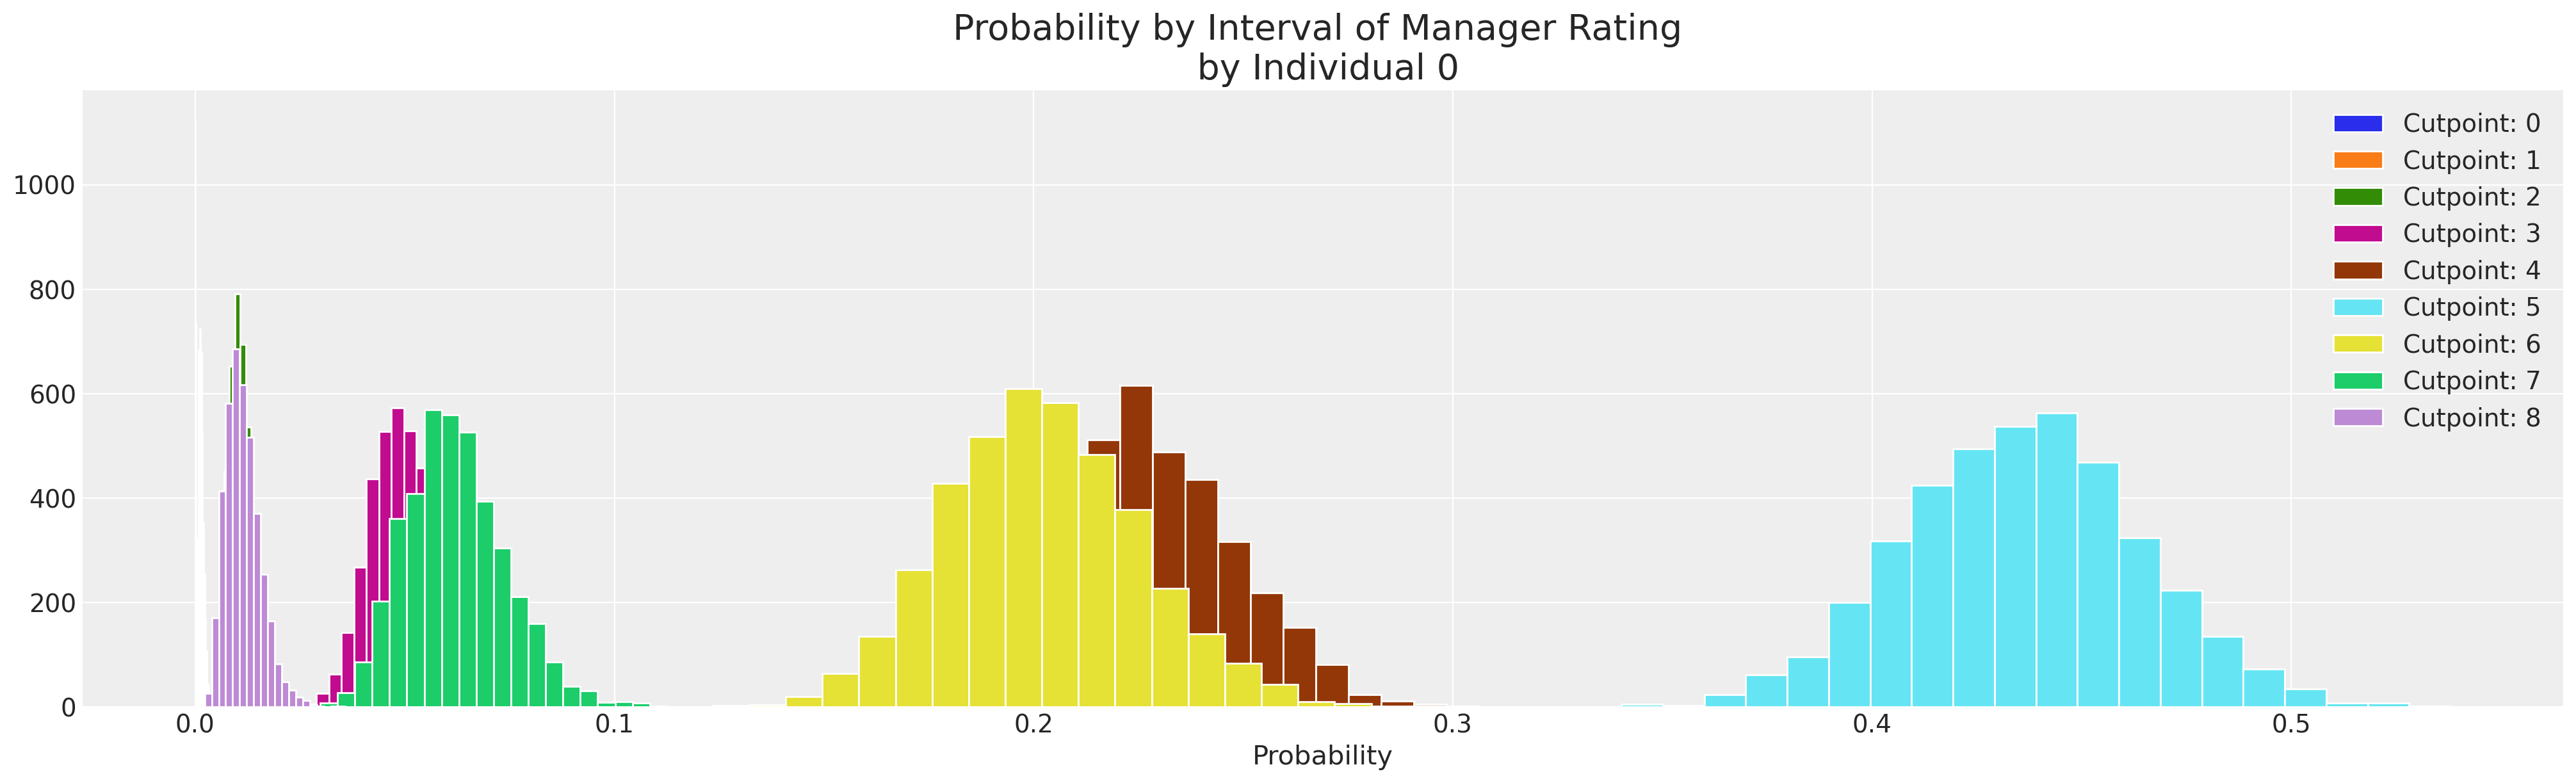

In [12]:
fig, ax = plt.subplots(figsize=(20, 6))
for i in range(K):
    ax.hist(implied_probs[0, i, :], label=f"Cutpoint: {i}", ec="white", bins=20)
ax.set_xlabel("Probability")
ax.set_title("Probability by Interval of Manager Rating \n by Individual 0", fontsize=20)
ax.legend();

In [13]:
implied_class = az.extract(idata3, var_names=["y"], group="posterior_predictive")
implied_class.shape

(500, 4000)

In [14]:
from scipy.stats import mode

mode(implied_class[0])

/var/folders/__/ng_3_9pn1f11ftyml_qr69vh0000gn/T/ipykernel_92274/3701407745.py:2: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode(implied_class[0])


ModeResult(mode=array([5]), count=array([1726]))

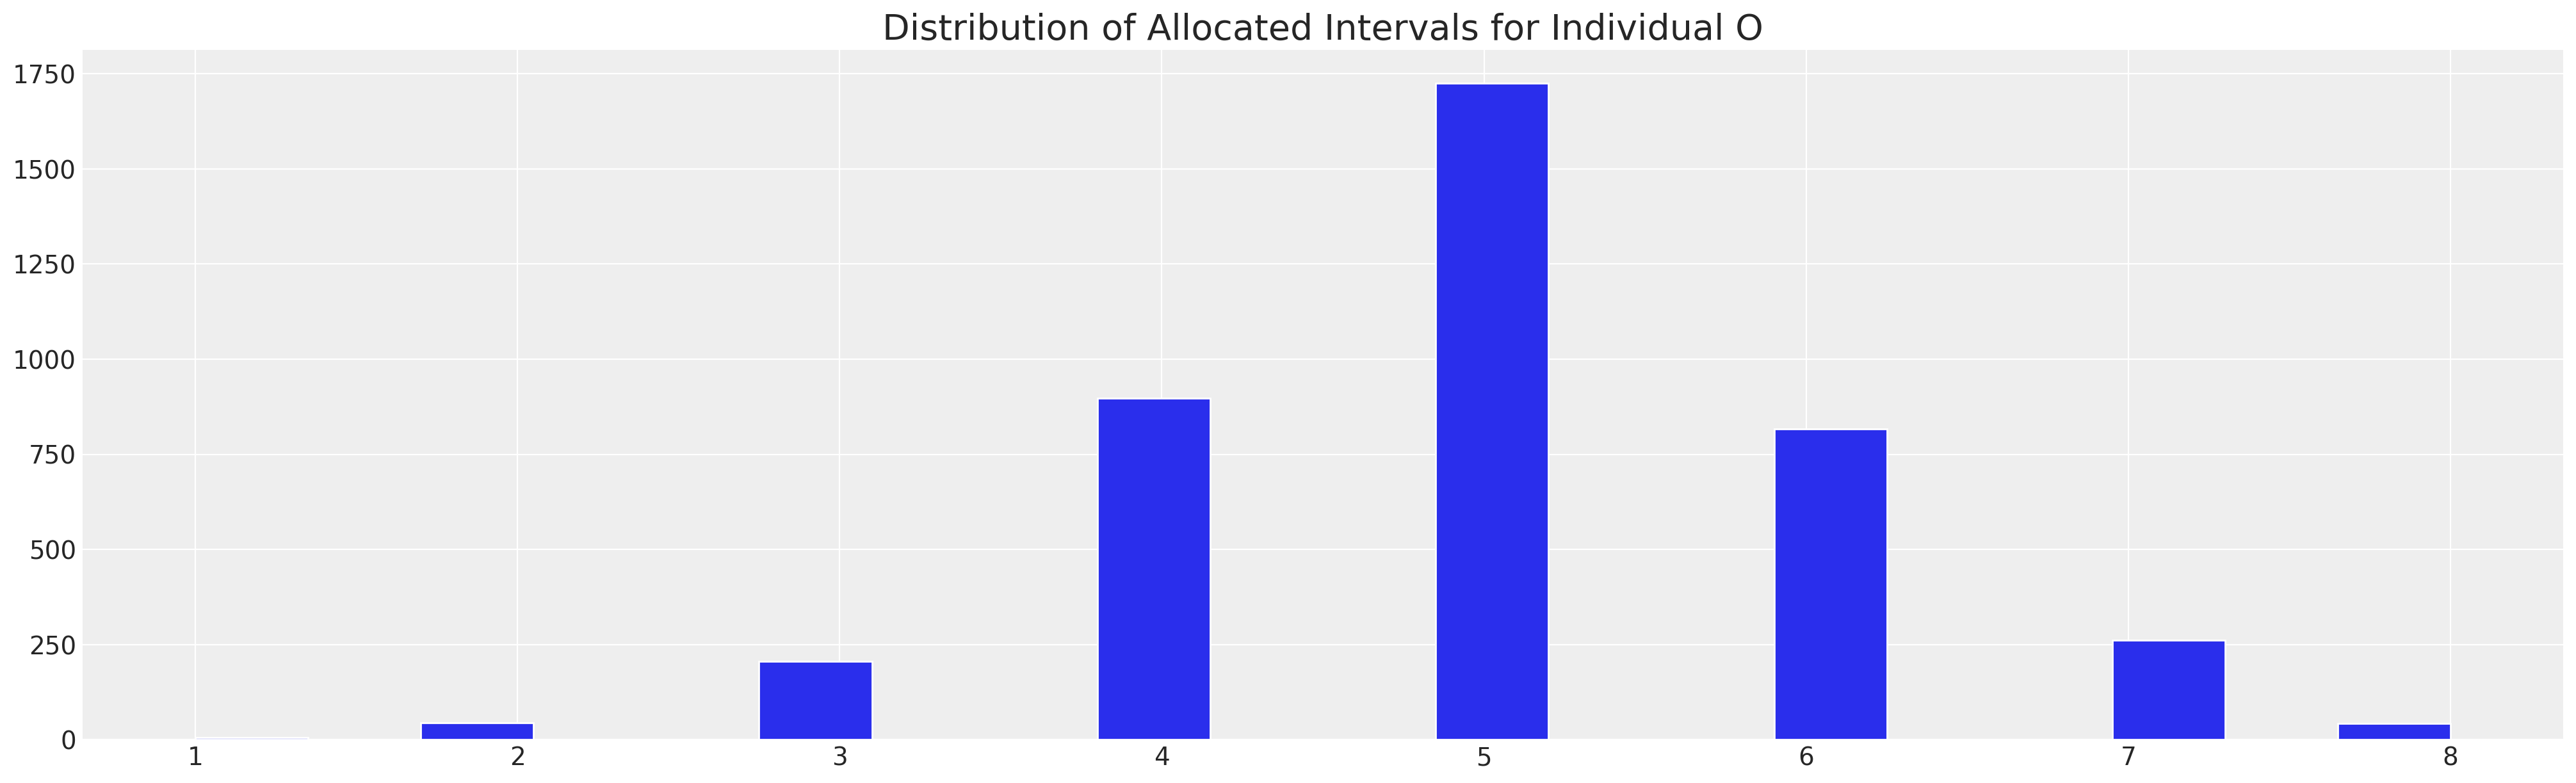

In [15]:
fig, ax = plt.subplots(figsize=(20, 6))
ax.hist(implied_class[0], ec="white", bins=20)
ax.set_title("Distribution of Allocated Intervals for Individual O", fontsize=20);

## Compare Models: Parameter Fits and LOO

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
model_full,0,-738.350532,11.721425,0.000000,8.076463e-01,16.692945,0.000000,False,log
constrained_logit_full,1,-749.161746,7.670766,10.811214,1.923537e-01,12.732569,6.817116,False,log
constrained_probit_full,2,-749.328539,7.833801,10.978007,1.034422e-14,12.767001,6.821424,False,log
model_salary,3,-825.650680,8.423640,87.300149,4.686321e-15,15.911663,12.487027,False,log
model_salary_worksat,4,-826.657751,9.519989,88.307219,0.000000e+00,15.890405,12.474427,False,log


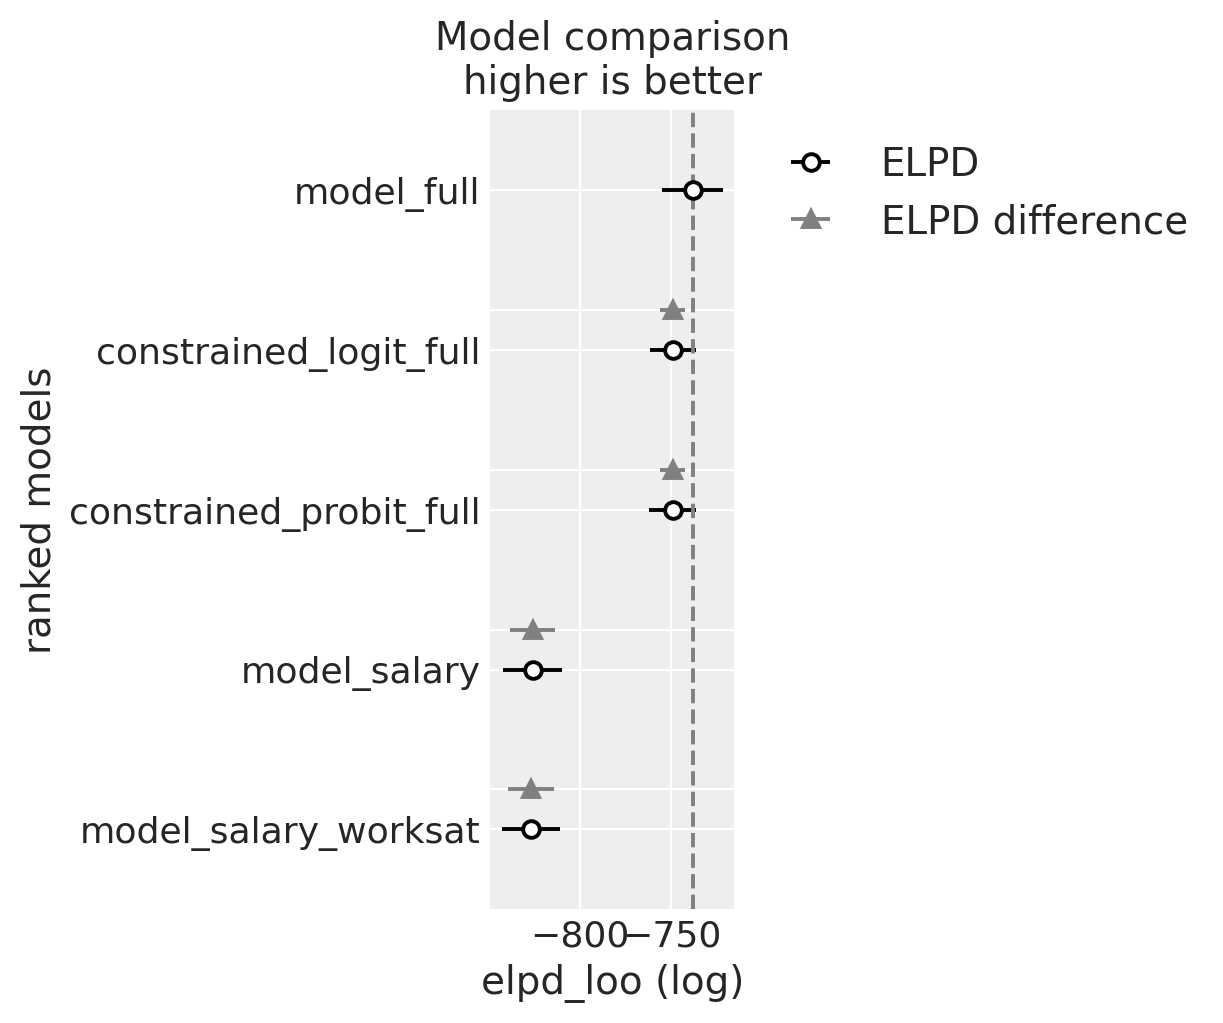

In [16]:
compare = az.compare(
    {
        "model_salary": idata1,
        "model_salary_worksat": idata2,
        "model_full": idata3,
        "constrained_logit_full": idata4,
        "constrained_probit_full": idata5,
    }
)

az.plot_compare(compare)
compare

/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.11/site-packages/arviz/stats/diagnostics.py:592: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


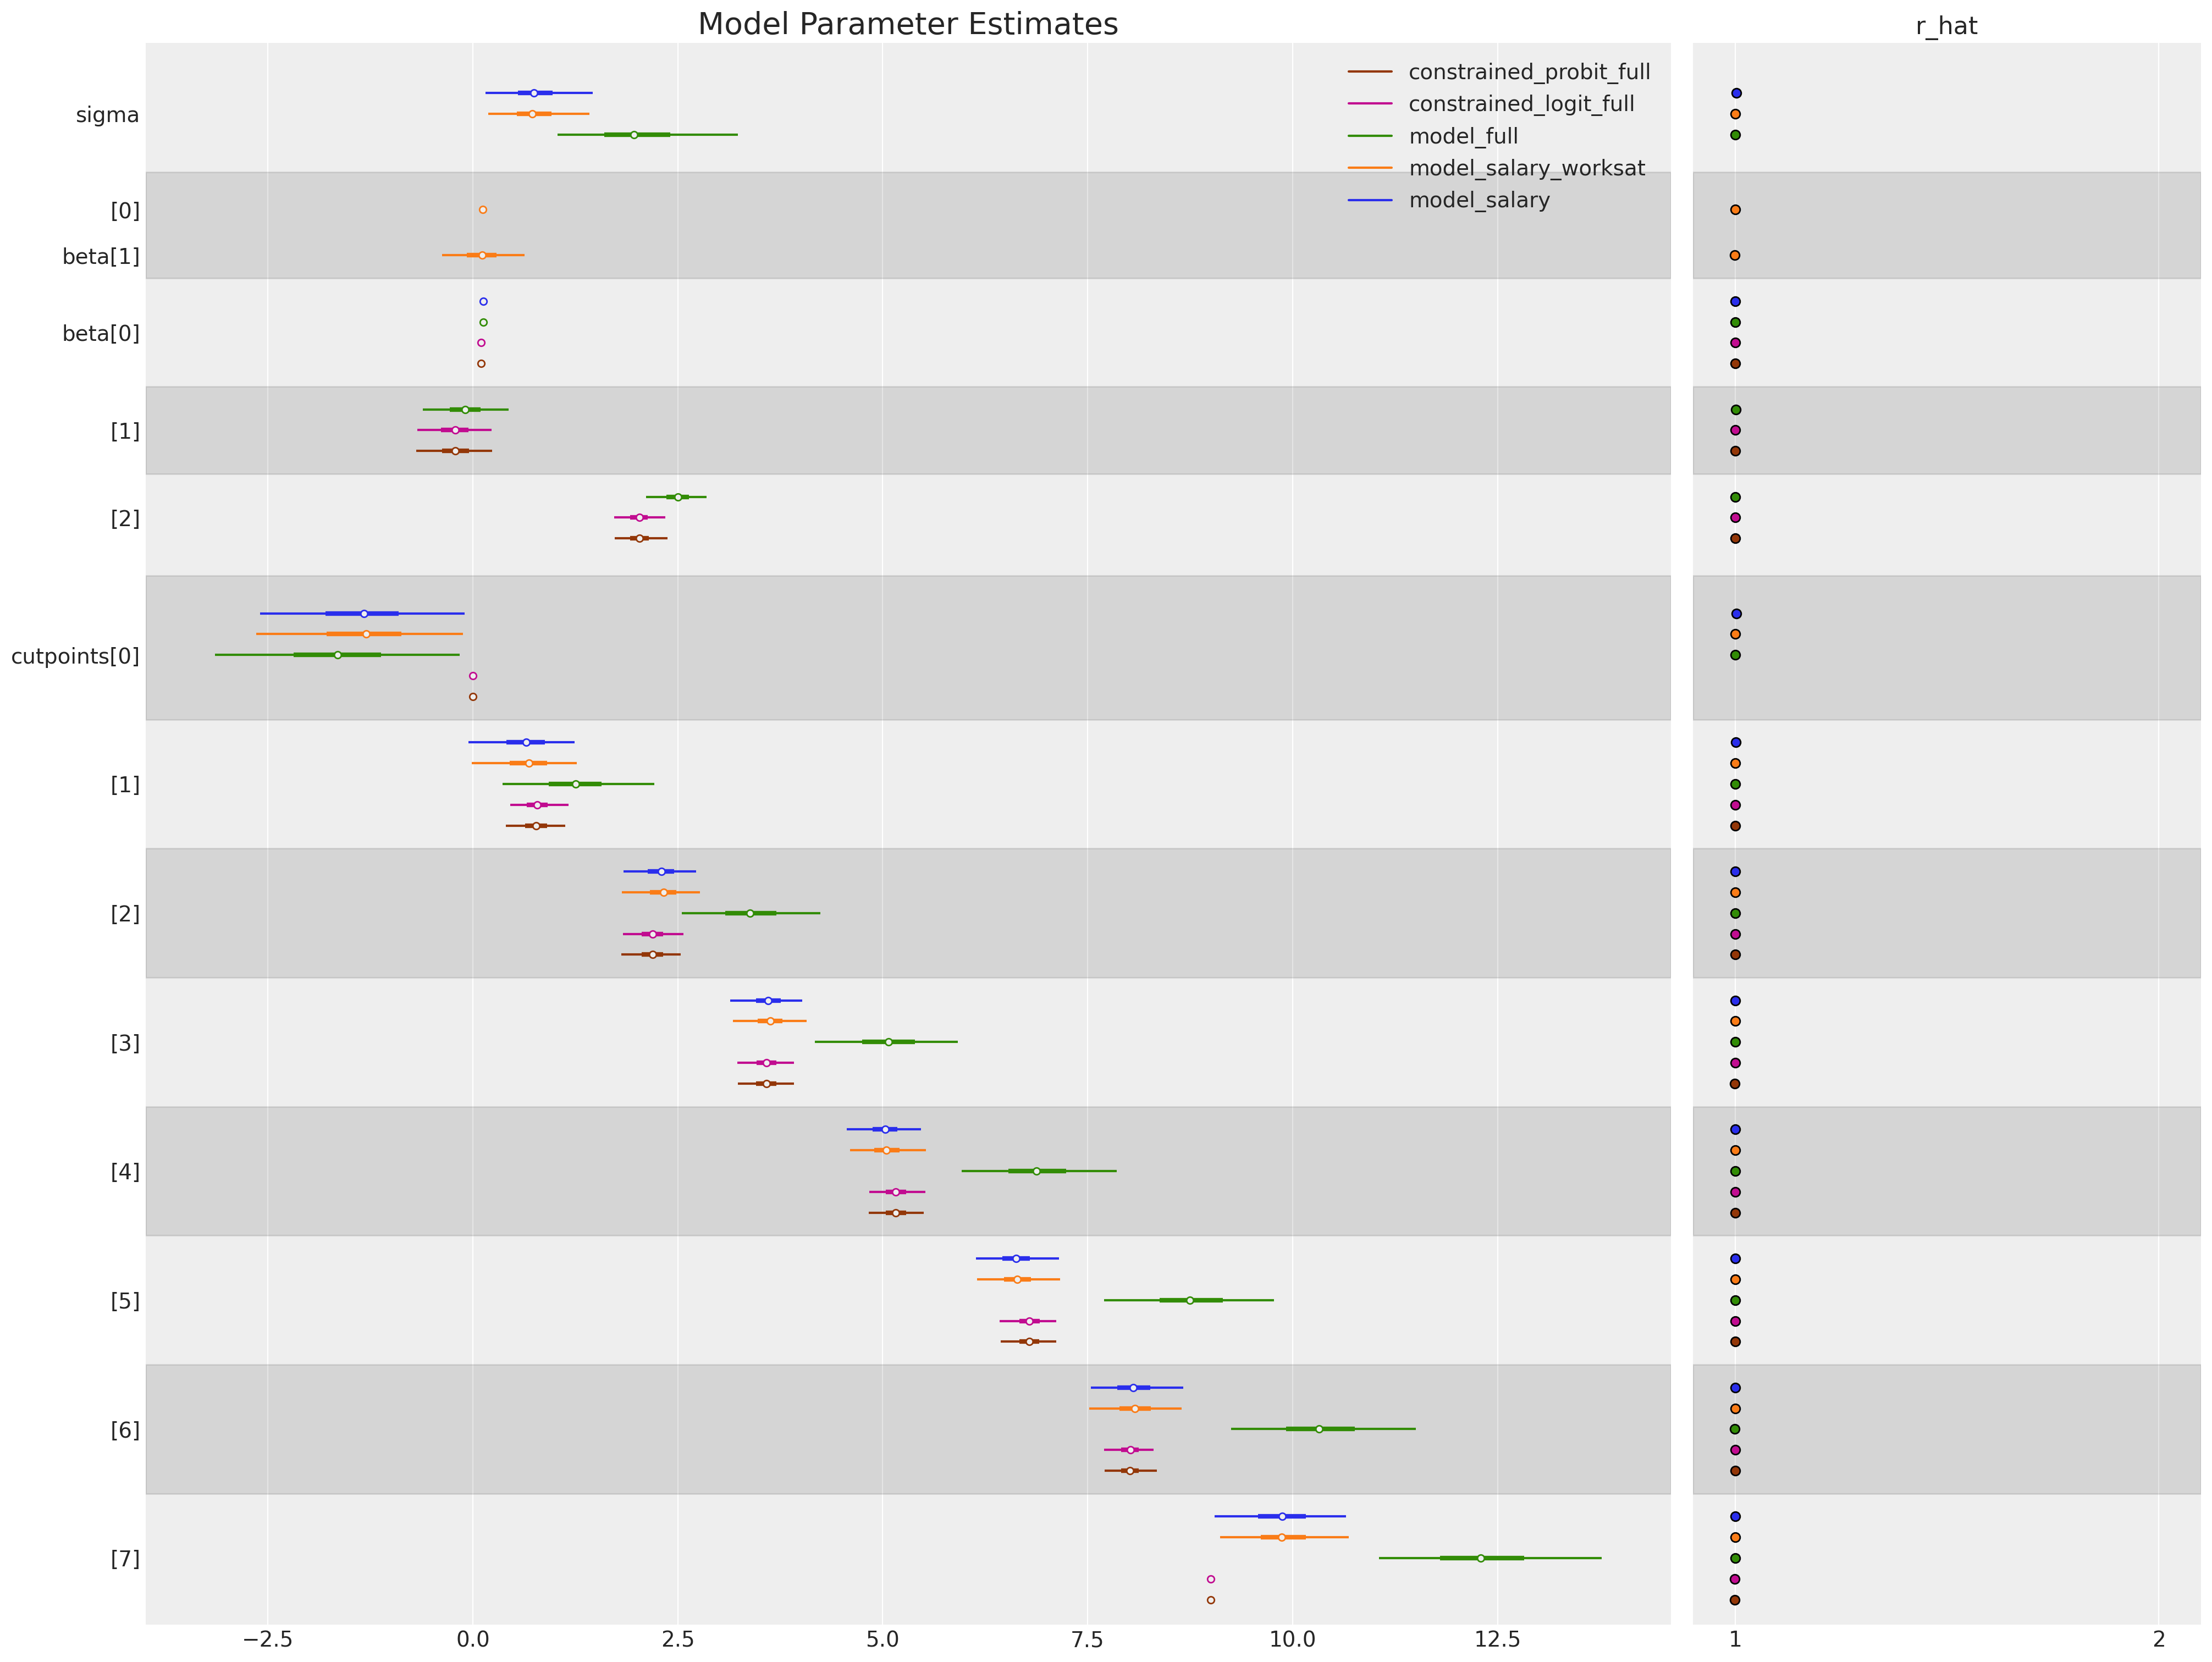

In [17]:
ax = az.plot_forest(
    [idata1, idata2, idata3, idata4, idata5],
    var_names=["sigma", "beta", "cutpoints"],
    combined=True,
    ridgeplot_overlap=4,
    figsize=(20, 15),
    r_hat=True,
    ridgeplot_alpha=0.3,
    model_names=[
        "model_salary",
        "model_salary_worksat",
        "model_full",
        "constrained_logit_full",
        "constrained_probit_full",
    ],
)
ax[0].set_title("Model Parameter Estimates", fontsize=20);

In [18]:
az.summary(idata3, var_names=["cutpoints", "beta", "sigma"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
cutpoints[0],-1.675,0.801,-3.145,-0.158,0.016,0.012,2522.0,2309.0,1.0
cutpoints[1],1.256,0.493,0.359,2.215,0.008,0.006,4019.0,3161.0,1.0
cutpoints[2],3.395,0.453,2.550,4.237,0.008,0.006,3381.0,3387.0,1.0
cutpoints[3],5.075,0.472,4.171,5.919,0.009,0.006,2937.0,3117.0,1.0
cutpoints[4],6.887,0.514,5.965,7.852,0.010,0.007,2788.0,2939.0,1.0
cutpoints[5],8.764,0.562,7.703,9.776,0.011,0.008,2633.0,2903.0,1.0
cutpoints[6],10.343,0.613,9.252,11.506,0.012,0.008,2615.0,2327.0,1.0
cutpoints[7],12.317,0.730,11.052,13.769,0.014,0.010,2800.0,2940.0,1.0
beta[0],0.130,0.010,0.111,0.149,0.000,0.000,3332.0,3082.0,1.0
beta[1],-0.094,0.278,-0.608,0.433,0.004,0.005,4195.0,2681.0,1.0


## Compare Cutpoints: Normal V Uniform Priors

Note how the model with unconstrianed cutpoints allows the occurence of a threshold estimated to be below zero. This does not make much conceptual sense, but can lead to a plausible enough posterior predictive distribution.

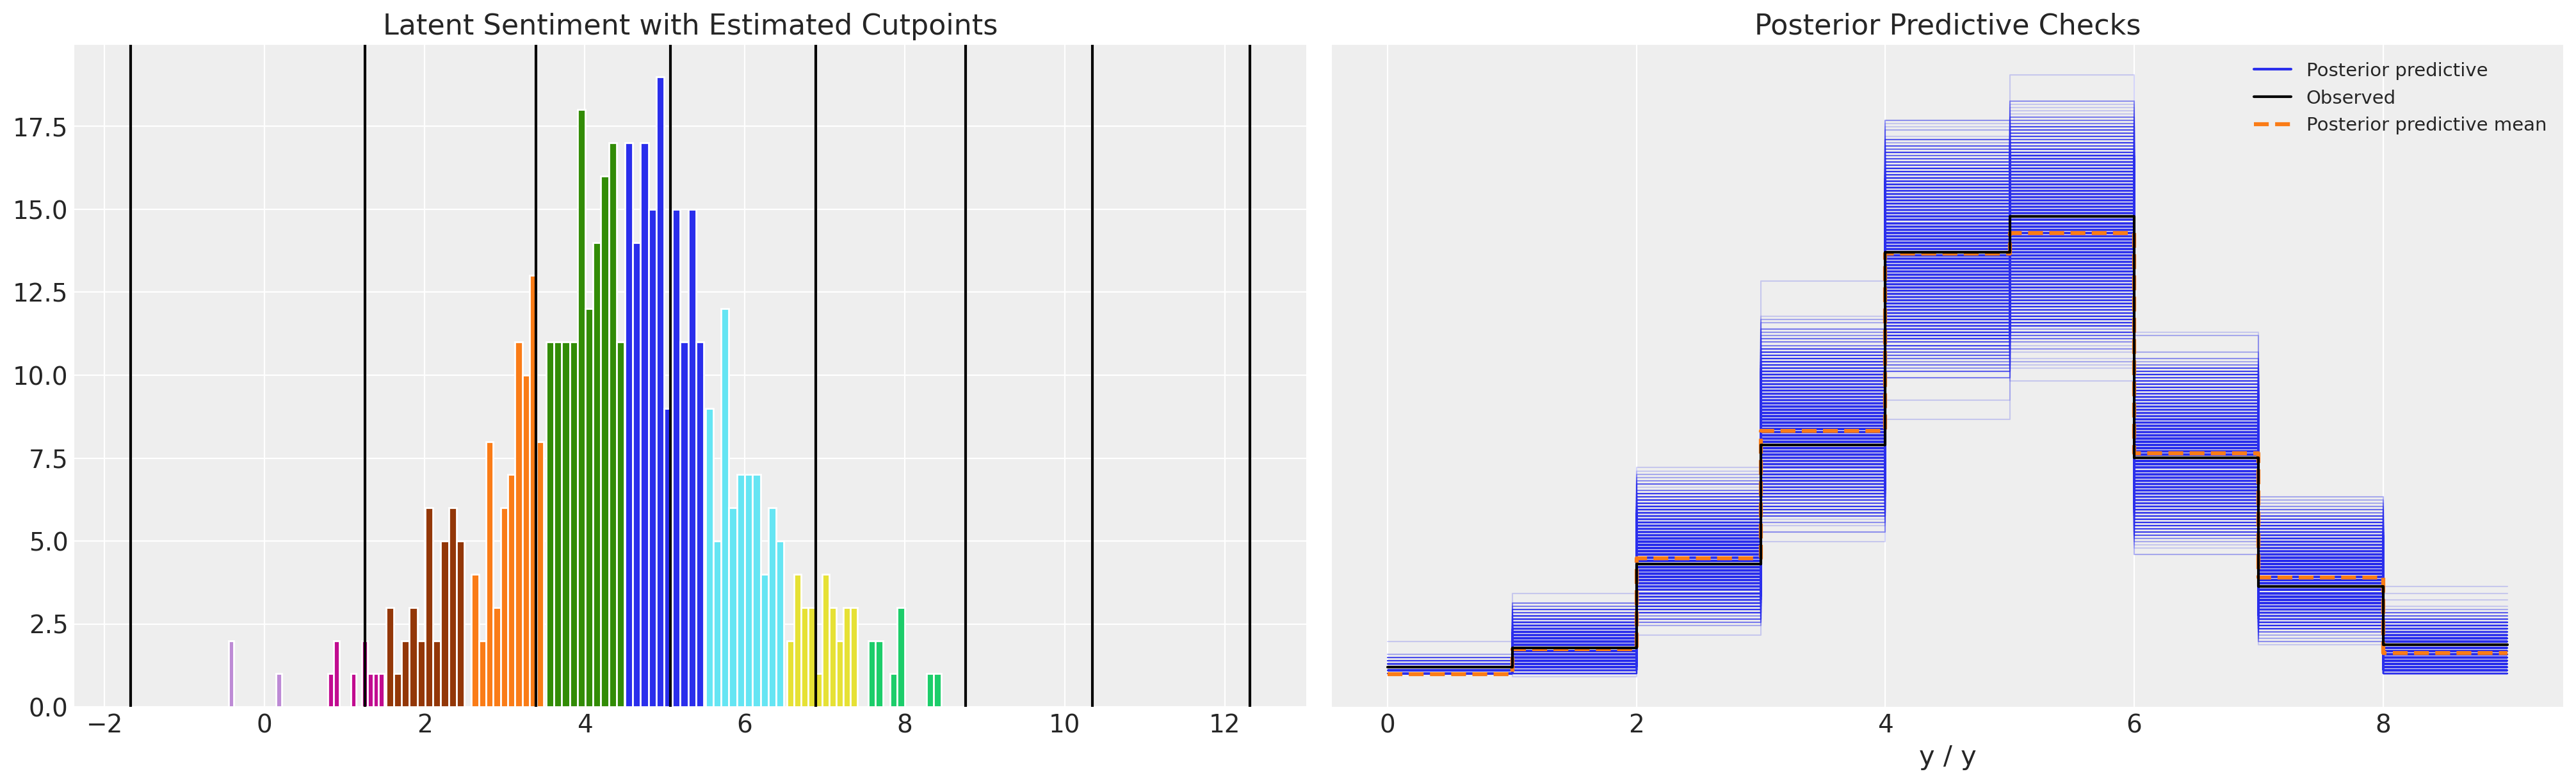

In [19]:
def plot_fit(idata):
    posterior = idata.posterior.stack(sample=("chain", "draw"))
    fig, axs = plt.subplots(1, 2, figsize=(20, 6))
    axs = axs.flatten()
    ax = axs[0]
    for i in range(K - 1):
        ax.axvline(posterior["cutpoints"][i].mean().values, color="k")
    for r in df["explicit_rating"].unique():
        temp = df[df["explicit_rating"] == r]
        ax.hist(temp["latent_rating"], ec="white")
    ax.set_title("Latent Sentiment with Estimated Cutpoints")
    axs[1].set_title("Posterior Predictive Checks")
    az.plot_ppc(idata, ax=axs[1])
    plt.show()


plot_fit(idata3)

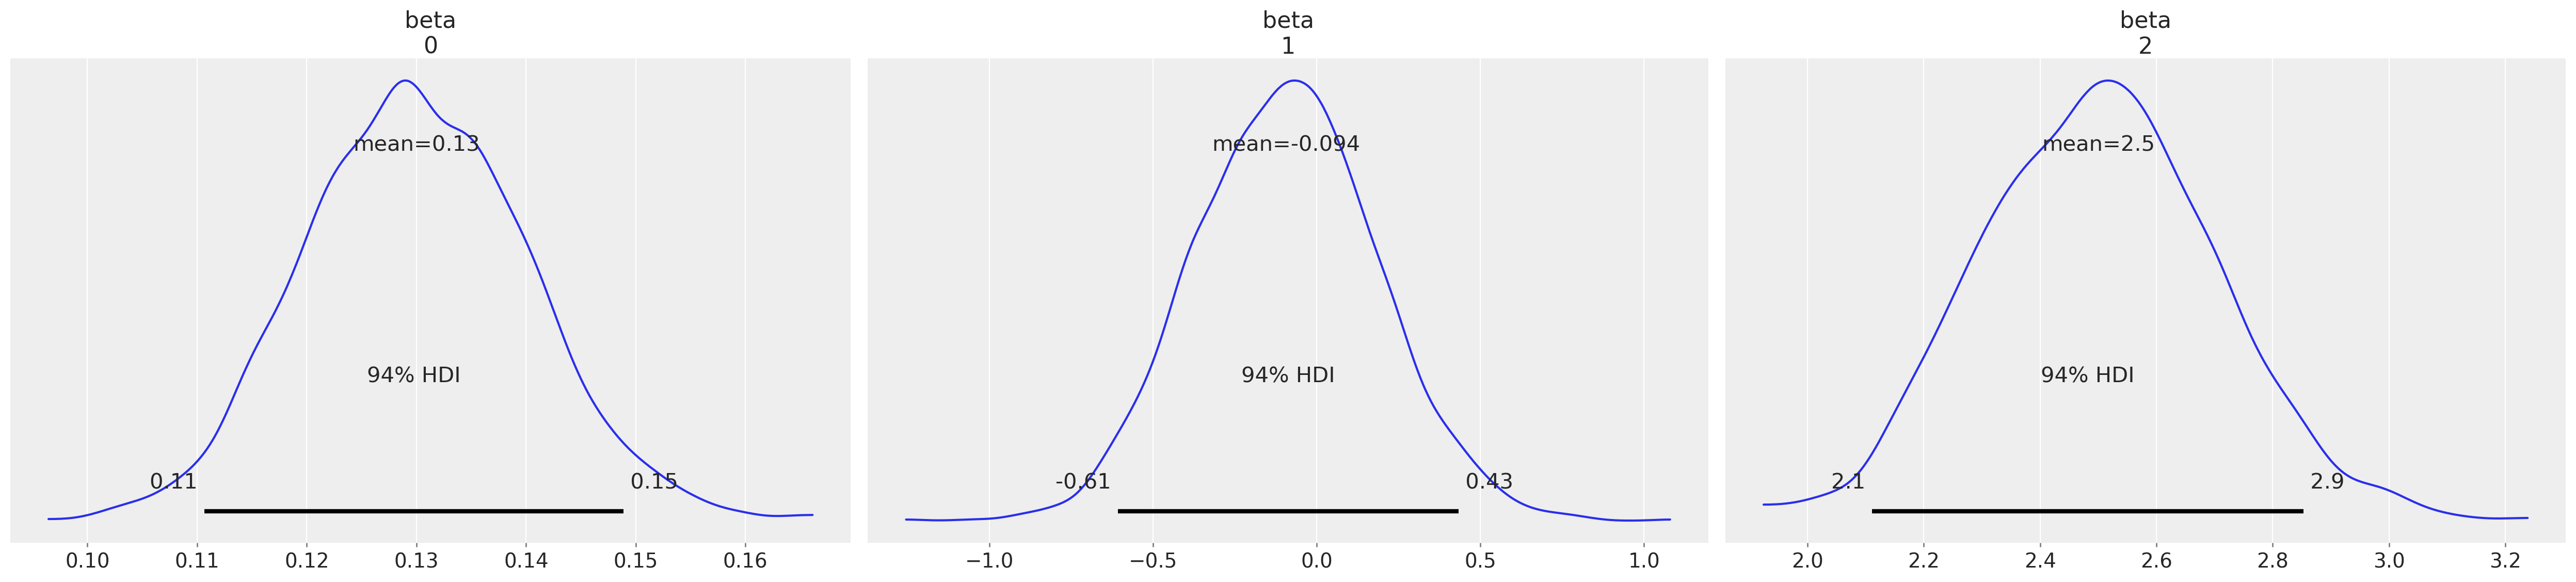

In [20]:
az.plot_posterior(idata3, var_names=["beta"]);

While the parameter estimates seem reasonable and the posterior predictive checks seem good too, the point to see here is that the cutpoints are unconstrained by the definition of the ordinal scale. They vary below 0 in the above model.

However if we look at the model with the constrained Dirchlet prior: 

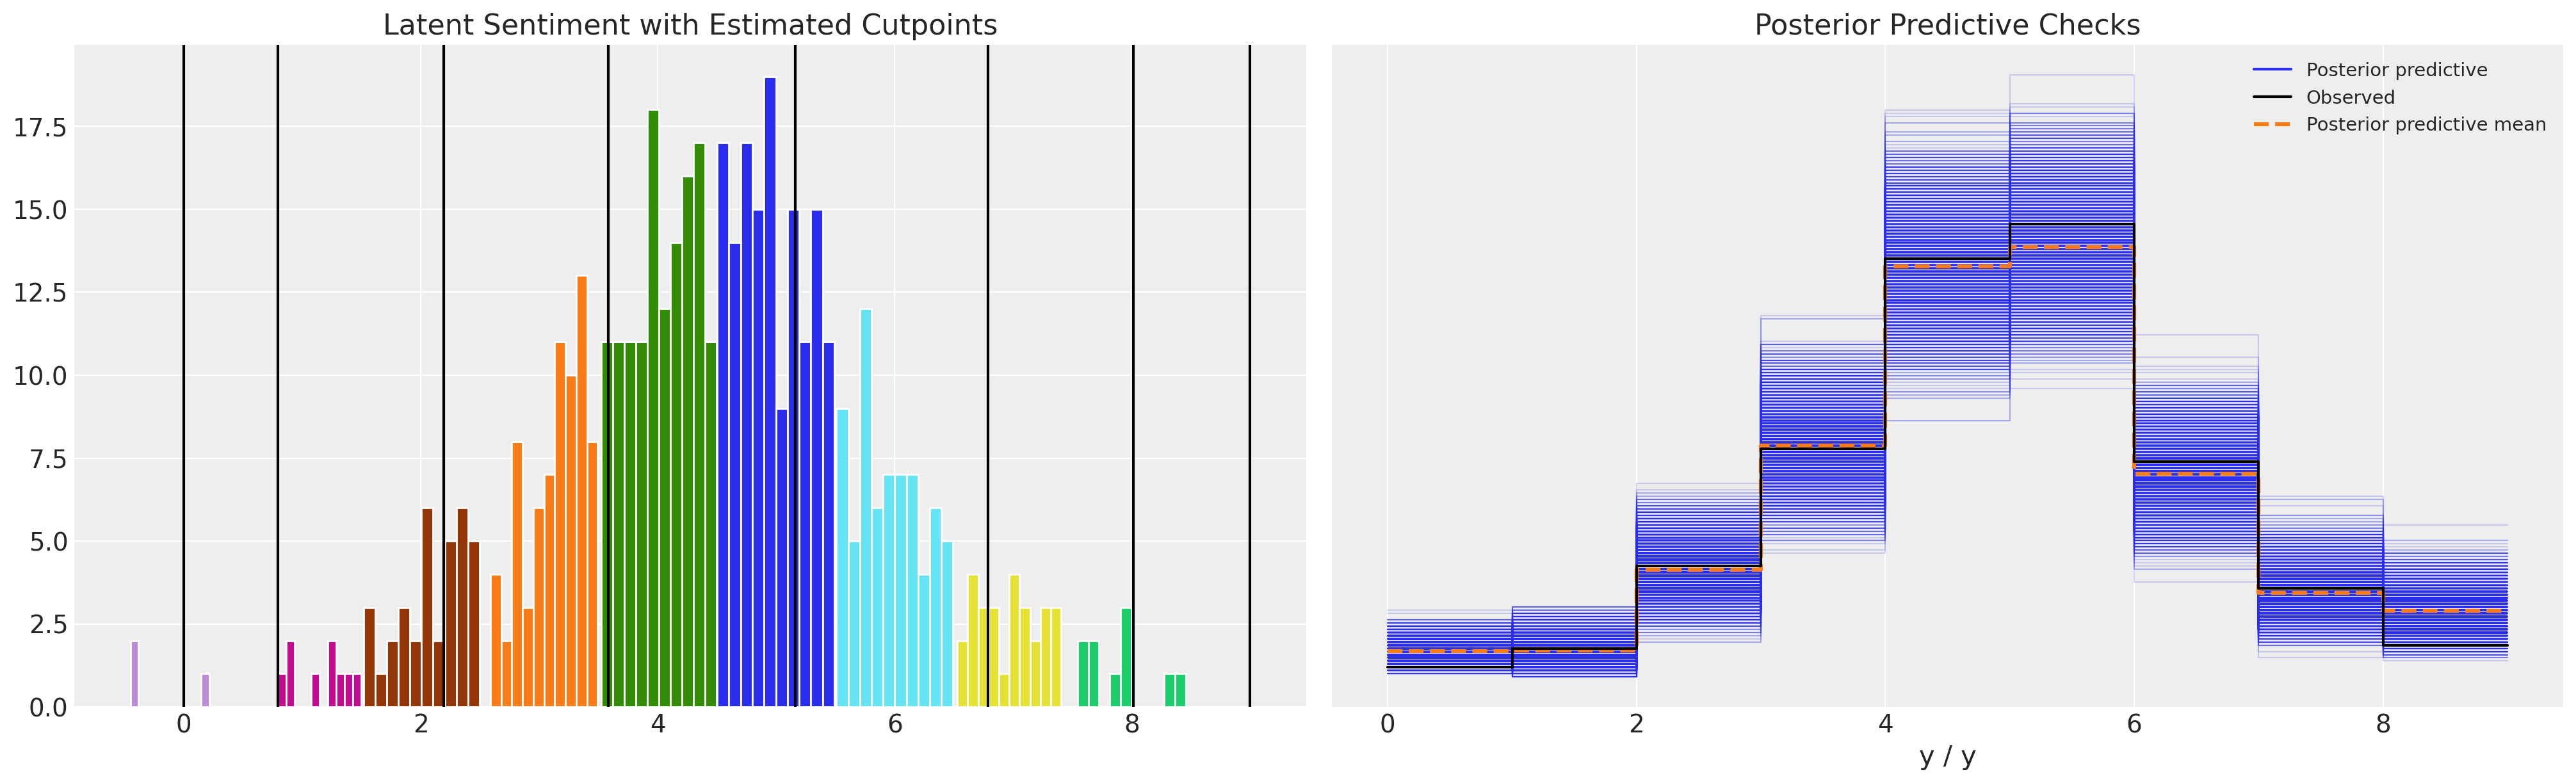

In [21]:
plot_fit(idata4)

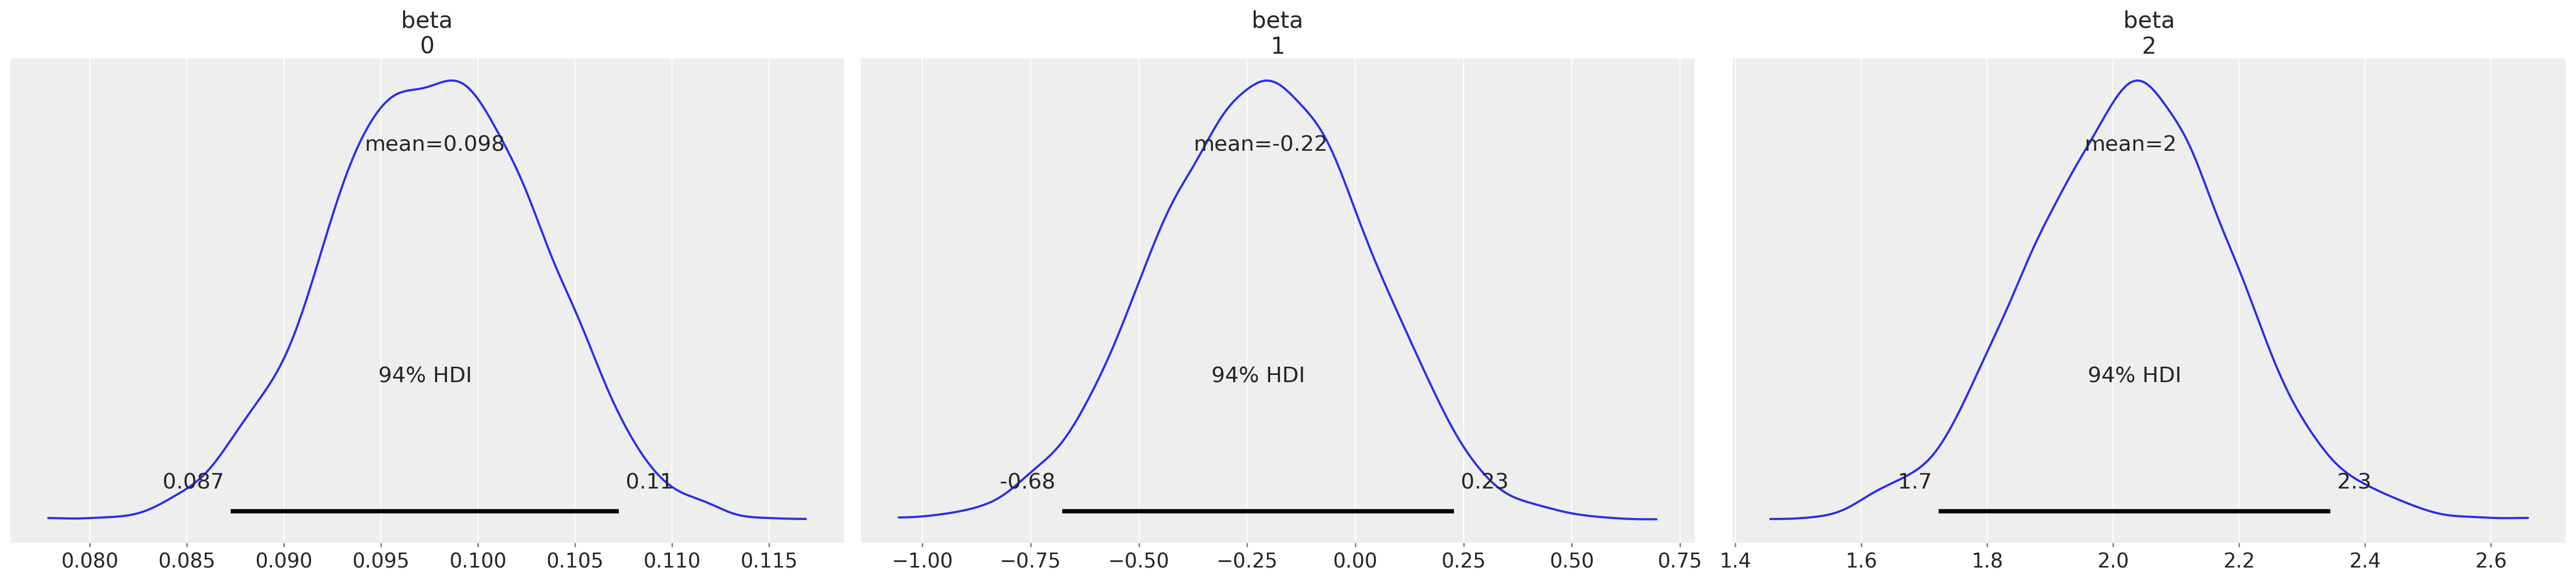

In [22]:
az.plot_posterior(idata4, var_names=["beta"]);

Again the parameters seem reasonable, and posterior predictive checks are sound. But now, having using the constrained uniform prior over the cutpoints our estimated cutpoints respect the definition of the ordinal scale. 

## Comparison to Statsmodels

In [23]:
modf_logit = OrderedModel.from_formula(
    "explicit_rating ~ salary + work_sat + work_from_home", df, distr="logit"
)
resf_logit = modf_logit.fit(method="bfgs")
resf_logit.summary()

Optimization terminated successfully.
         Current function value: 1.447704
         Iterations: 59
         Function evaluations: 65
         Gradient evaluations: 65


<class 'statsmodels.iolib.summary.Summary'>
"""
                             OrderedModel Results                             
==============================================================================
Dep. Variable:        explicit_rating   Log-Likelihood:                -723.85
Model:                   OrderedModel   AIC:                             1470.
Method:            Maximum Likelihood   BIC:                             1516.
Date:                Wed, 22 Mar 2023                                         
Time:                        19:28:49                                         
No. Observations:                 500                                         
Df Residuals:                     489                                         
Df Model:                          11                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
salary             0.1349      0.010     13.457      0.000       0.115       0.155
work_sat           0.0564      0.286      0.197      0.844      -0.504       0.617
work_from_home     2.5985      0.206     12.590      0.000       2.194       3.003
-0.0/1.0           0.2158      0.693      0.312      0.755      -1.142       1.573
1.0/2.0            0.5127      0.332      1.543      0.123      -0.138       1.164
2.0/3.0            0.6502      0.161      4.034      0.000       0.334       0.966
3.0/4.0            0.4962      0.108      4.598      0.000       0.285       0.708
4.0/5.0            0.6032      0.080      7.556      0.000       0.447       0.760
5.0/6.0            0.6399      0.076      8.474      0.000       0.492       0.788
6.0/7.0            0.4217      0.113      3.725      0.000       0.200       0.644
7.0/8.0            0.5054      0.186      2.712      0.007       0.140       0.871
==================================================================================
"""

## Kruschke's IMDB movie Ratings Data

There are substantial reasons for using an ordinal regression model rather than trusting to alternatives. The temptation to treat the ordered category as a continuous metric will lead to false inferences. The details are discussed in Kruschke's paper on this topic. We'll briefly replicate his example about this phenomenon can appear in analysis of movies ratings data.

In [24]:
movies = pd.read_csv("../data/MoviesData.csv")
movies.head()

,ID,Descrip,n1,n2,n3,n4,n5
0,1,The Whole Truth,49,70,119,217,245
1,2,Priceless,67,22,22,60,574
2,3,Allied,59,76,102,203,406
3,4,The Infiltrator,173,216,518,1339,2073
4,5,Miss Sloane,180,60,48,120,793


In [25]:
import pandas as pd

movies = pd.read_csv("../data/MoviesData.csv")


def pivot_movie(row):
    row_ratings = row[["n1", "n2", "n3", "n4", "n5"]]
    totals = []
    for c, i in zip(row_ratings.index, range(5)):
        totals.append(row_ratings[c] * [i])
    totals = [item for sublist in totals for item in sublist]
    movie = [row["Descrip"]] * len(totals)
    id = [row["ID"]] * len(totals)
    return pd.DataFrame({"rating": totals, "movie": movie, "movie_id": id})


movies_by_rating = pd.concat([pivot_movie(movies.iloc[i]) for i in range(len(movies))])
movies_by_rating.reset_index(inplace=True, drop=True)
movies_by_rating.shape

(284671, 3)

In [26]:
movies_by_rating.sample(100).head()

,rating,movie,movie_id
272009,4,The Marvelous Mrs Maisel Season 1,30
56137,2,Sneaky Pete Season 1,19
186806,4,The Man in the High Castle Season 1,23
101576,4,Sneaky Pete Season 1,19
261825,4,The Marvelous Mrs Maisel Season 1,30


In [27]:
def constrainedUniform(N, group, min=0, max=1):
    return pm.Deterministic(
        f"cutpoints_{group}",
        pt.concatenate(
            [
                np.ones(1) * min,
                pt.extra_ops.cumsum(pm.Dirichlet(f"cuts_unknown_{group}", a=np.ones(N - 2)))
                * (min + (max - min)),
            ]
        ),
    )

We will fit this data with both an ordinal model and as a metric. This will show how the ordinal fit is subtantially more compelling. 

In [28]:
K = 5
movies_by_rating = movies_by_rating[movies_by_rating["movie_id"].isin([1, 2, 3, 4, 5, 6])]
indx, unique = pd.factorize(movies_by_rating["movie_id"])
priors = {"sigma": 1, "mu": [0, 1], "cut_mu": np.linspace(0, K, K - 1)}


def make_movies_model(ordered=False):
    with pm.Model() as model:

        for g in movies_by_rating["movie_id"].unique():
            if ordered:
                cutpoints = constrainedUniform(K, g, 0, K - 1)
                mu = pm.Normal(f"mu_{g}", priors["mu"][0], priors["mu"][1])
                y_ = pm.OrderedLogistic(
                    f"y_{g}",
                    cutpoints=cutpoints,
                    eta=mu,
                    observed=movies_by_rating[movies_by_rating["movie_id"] == g].rating.values,
                )
            else:
                mu = pm.Normal(f"mu_{g}", 3, 1)
                sigma = pm.HalfNormal(f"sigma_{g}", 1)
                y_ = pm.Normal(
                    f"y_{g}",
                    mu,
                    sigma,
                    observed=movies_by_rating[movies_by_rating["movie_id"] == g].rating.values,
                )

        idata = pm.sample_prior_predictive()
        idata.extend(pm.sample(nuts_sampler="numpyro", idata_kwargs={"log_likelihood": True}))
        idata.extend(pm.sample_posterior_predictive(idata))
    return idata, model


idata_ordered, model_ordered = make_movies_model(ordered=True)
idata_normal_metric, model_normal_metric = make_movies_model(ordered=False)

Sampling: [cuts_unknown_1, cuts_unknown_2, cuts_unknown_3, cuts_unknown_4, cuts_unknown_5, cuts_unknown_6, mu_1, mu_2, mu_3, mu_4, mu_5, mu_6, y_1, y_2, y_3, y_4, y_5, y_6]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.11/site-packages/pymc/sampling/mcmc.py:242: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:04.139449
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:09.411700
Transforming variables...
Transformation time =  0:00:00.357081
Computing Log Likelihood...


Sampling: [y_1, y_2, y_3, y_4, y_5, y_6]


Log Likelihood time =  0:00:01.072750


Sampling: [mu_1, mu_2, mu_3, mu_4, mu_5, mu_6, sigma_1, sigma_2, sigma_3, sigma_4, sigma_5, sigma_6, y_1, y_2, y_3, y_4, y_5, y_6]
/Users/nathanielforde/mambaforge/envs/pymc_examples_new/lib/python3.11/site-packages/pymc/sampling/mcmc.py:242: UserWarning: Use of external NUTS sampler is still experimental
  warnings.warn("Use of external NUTS sampler is still experimental", UserWarning)


Compiling...
Compilation time =  0:00:01.290638
Sampling...


  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

Sampling time =  0:00:03.548902
Transforming variables...
Transformation time =  0:00:00.007405
Computing Log Likelihood...


Sampling: [y_1, y_2, y_3, y_4, y_5, y_6]


Log Likelihood time =  0:00:00.936338


### Posterior Predictive Fit: Normal Metric Model

This is a horrific fit to the movies rating data for six movies.

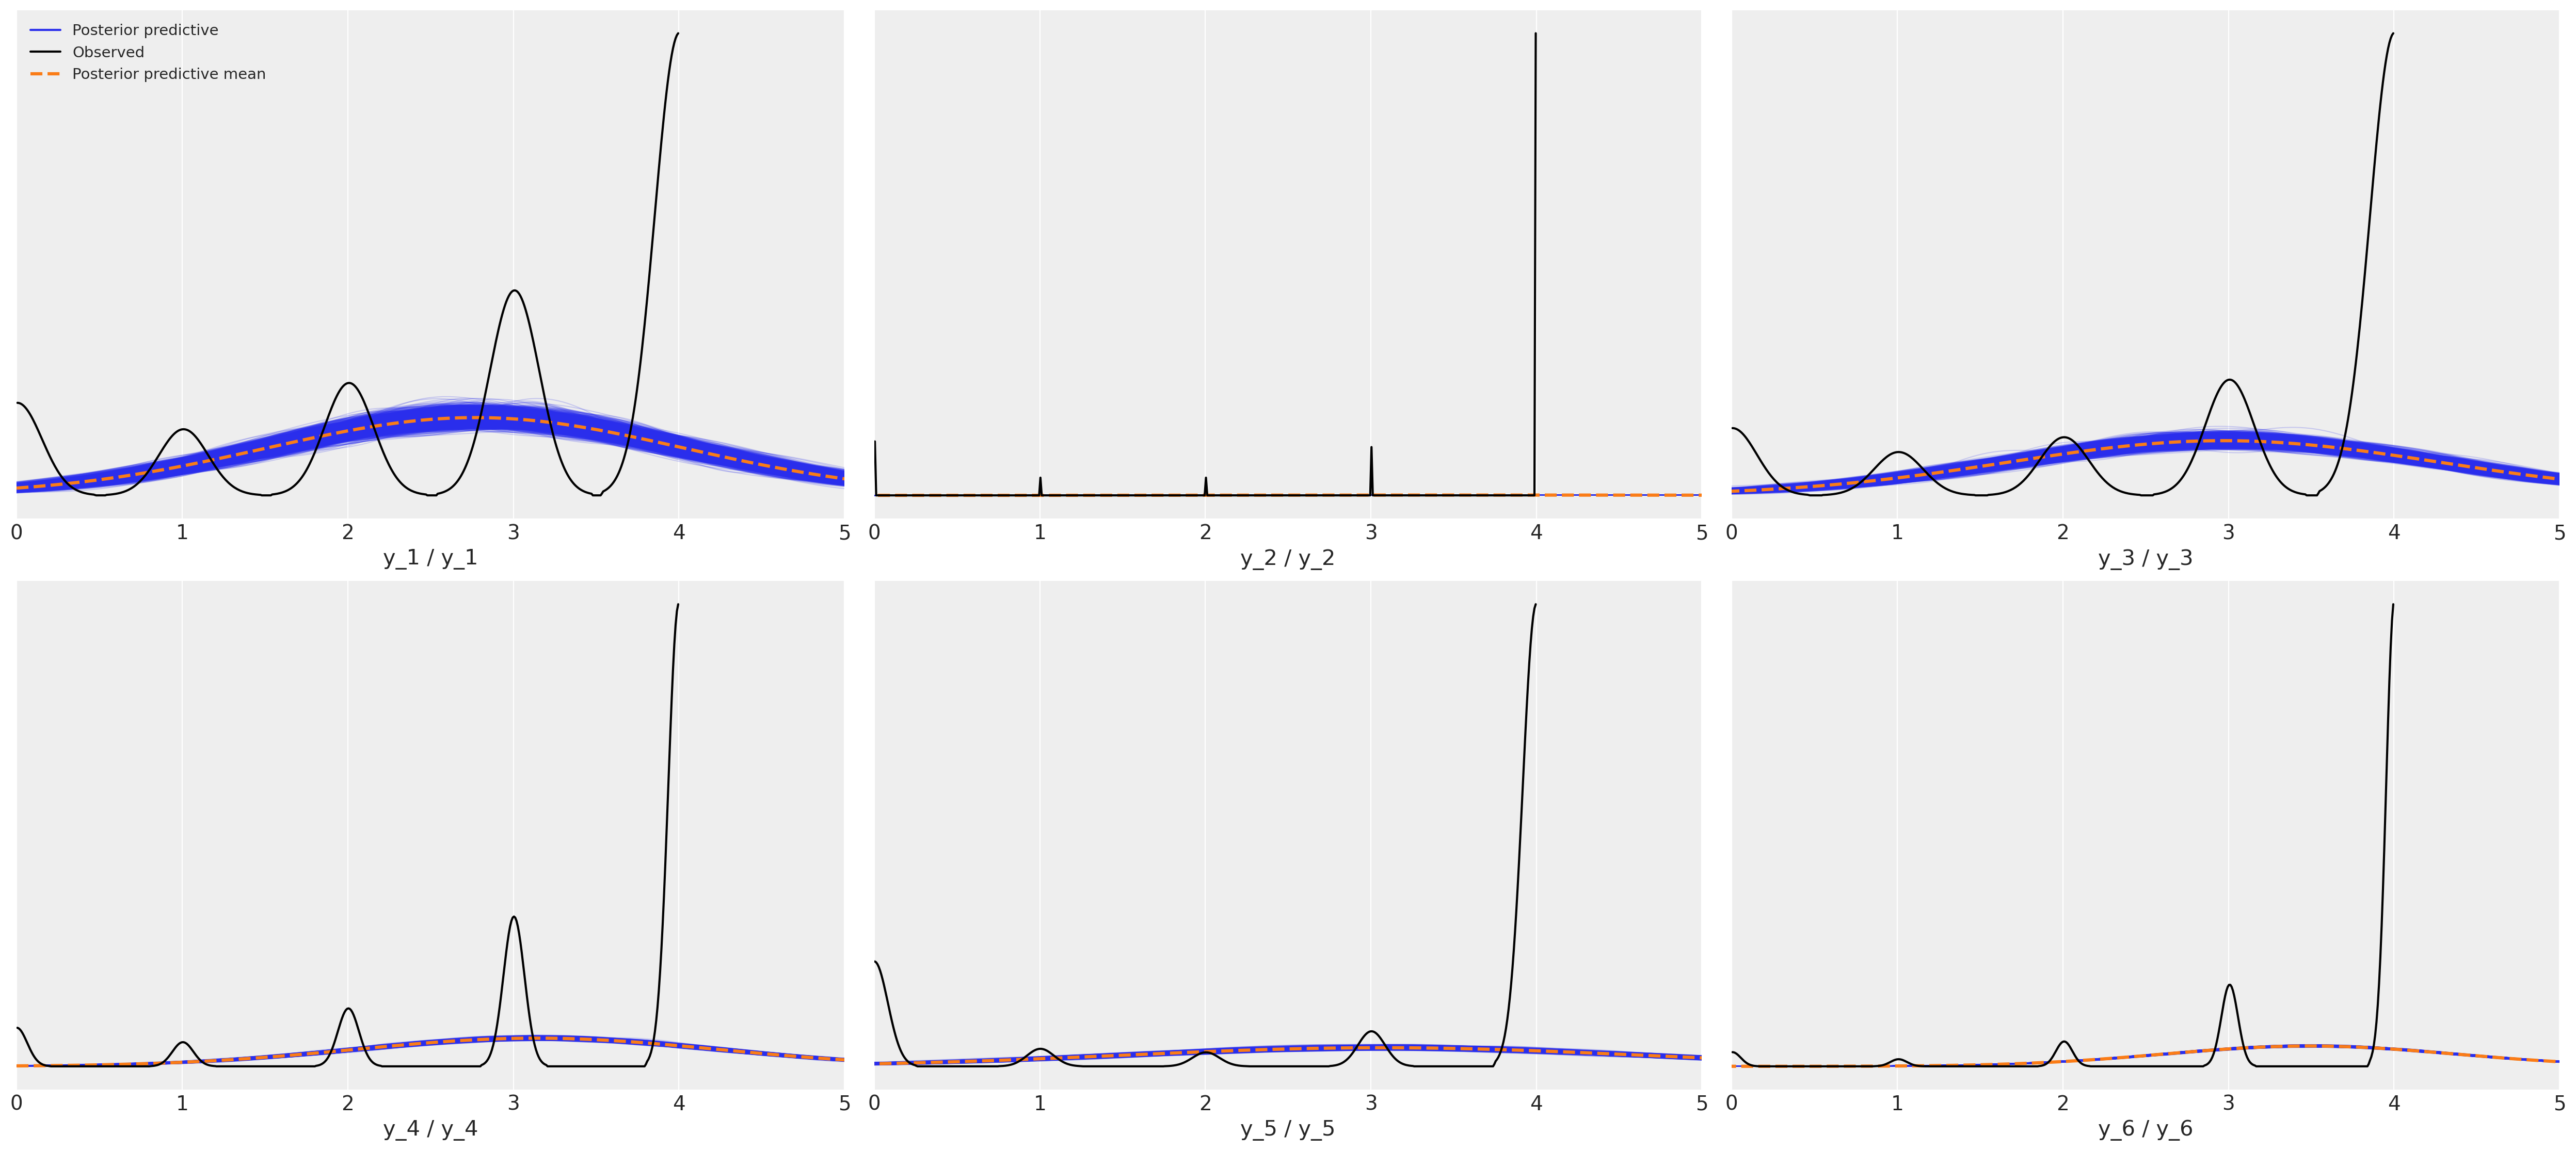

In [29]:
axs = az.plot_ppc(idata_normal_metric)
axs = axs.flatten()
for ax in axs:
    ax.set_xlim(0, 5);

### Posterior Predictive Fit: Ordered Response Model

This shows a much nicer fit for each of the six movies. 

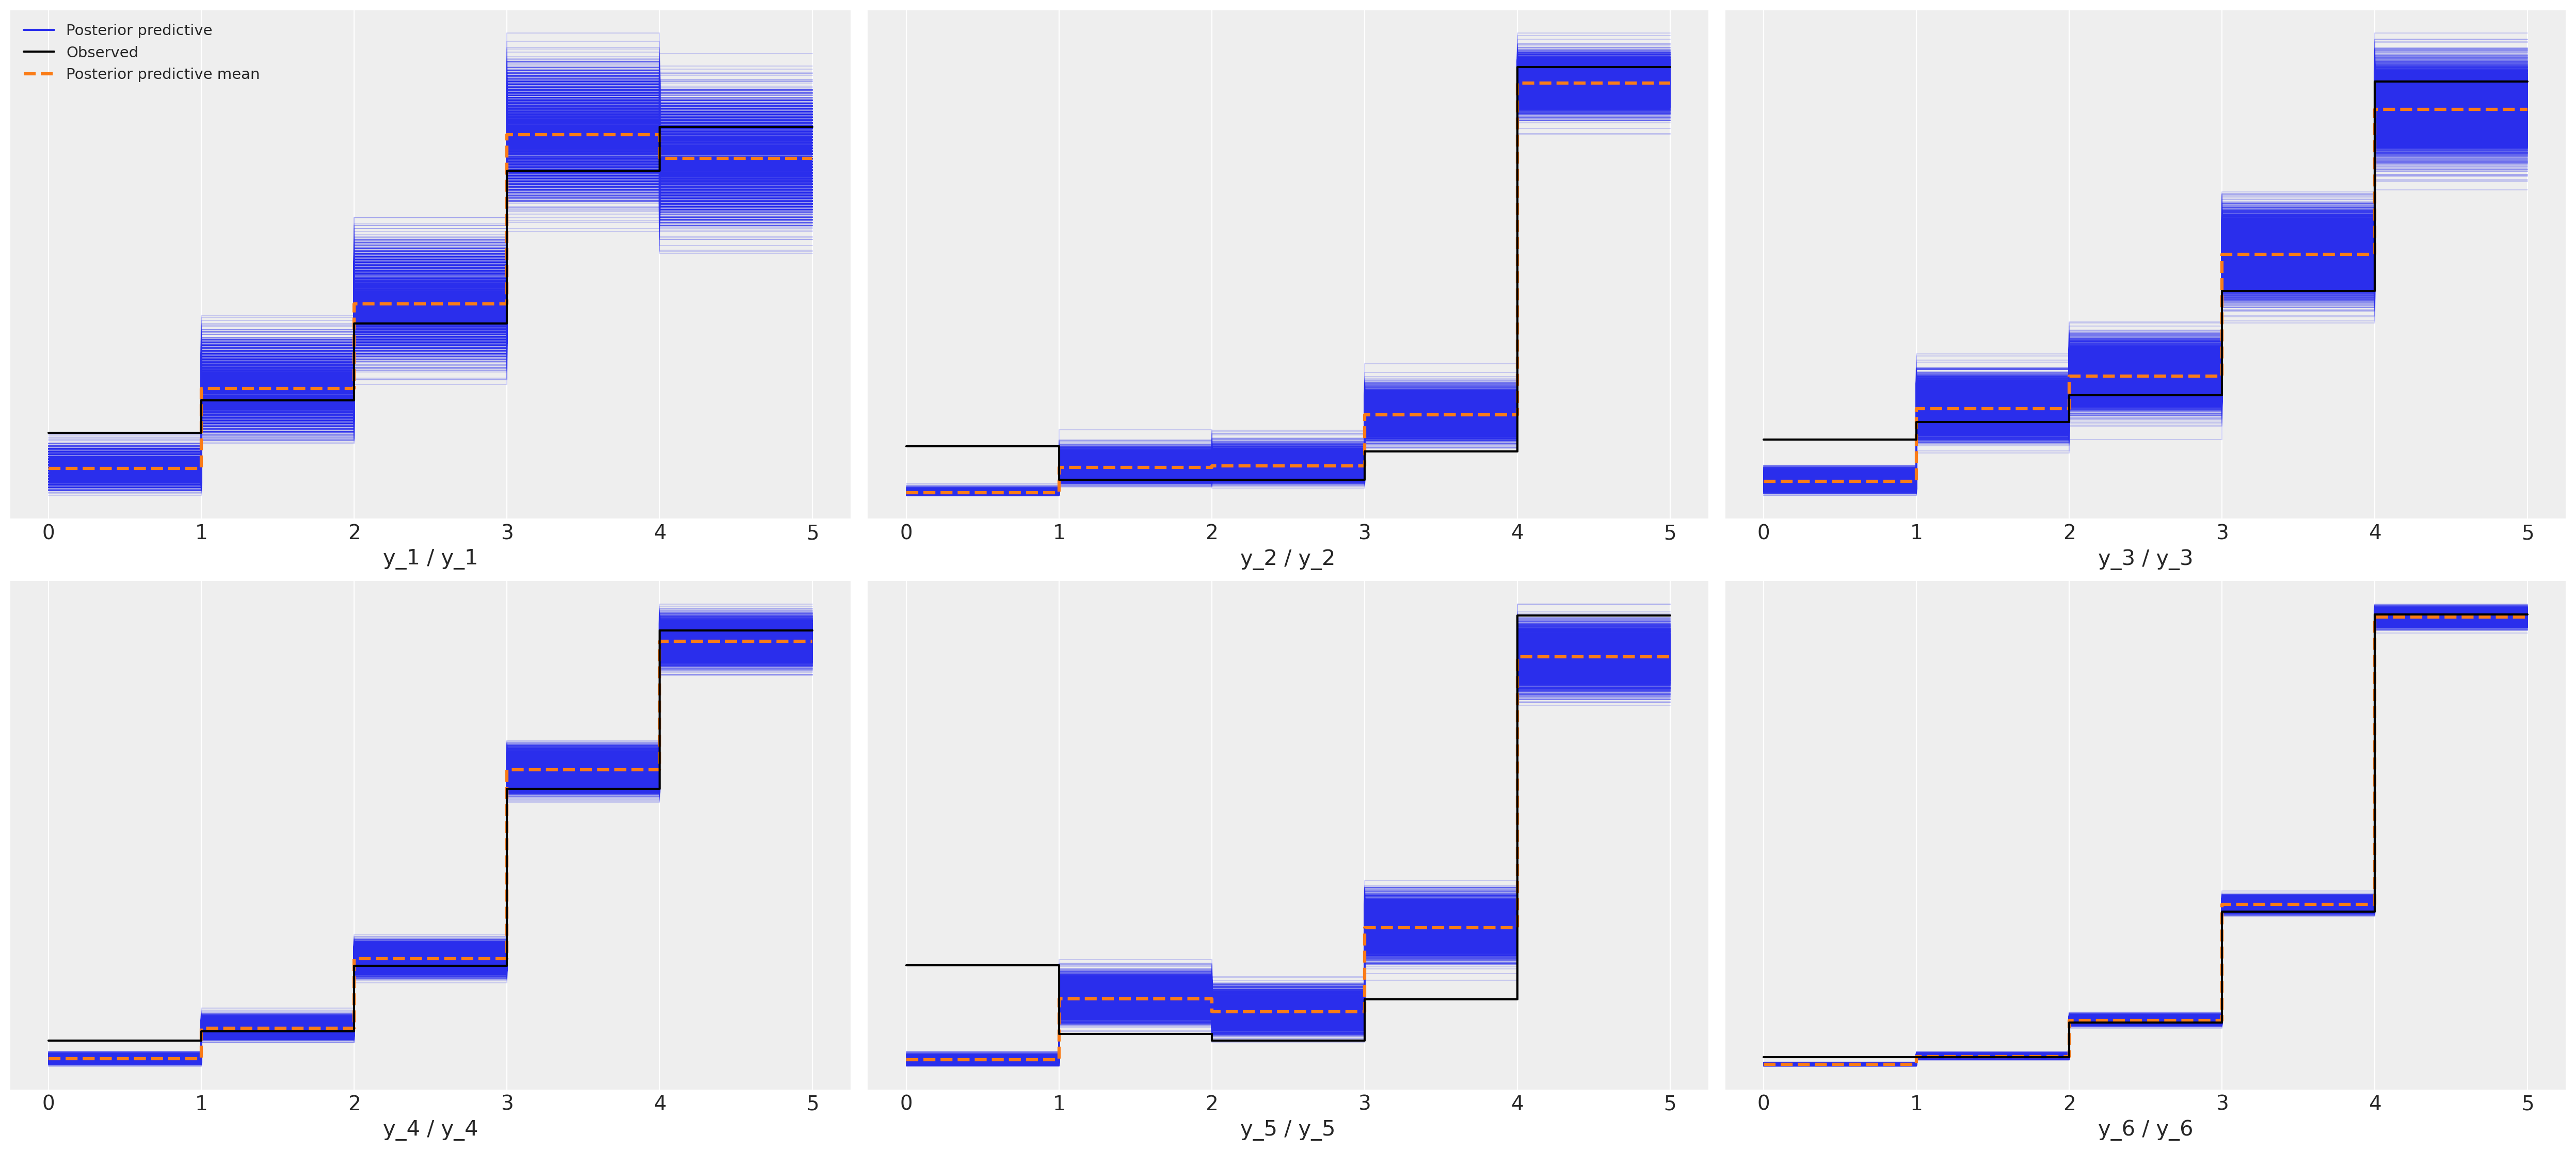

In [30]:
az.plot_ppc(idata_ordered);

### Compare Model Fits

In [31]:
y_5_compare = az.compare({"ordered": idata_ordered, "metric": idata_normal_metric}, var_name="y_5")
y_5_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
ordered,0,-1651.288878,3.492320,0.000000,1.0,48.835113,0.000000,False,log
metric,1,-2191.510204,1.992209,540.221327,0.0,24.146225,28.089692,False,log


In [32]:
y_6_compare = az.compare({"ordered": idata_ordered, "metric": idata_normal_metric}, var_name="y_6")
y_6_compare

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
ordered,0,-13339.175418,3.025899,0.000000,1.0,110.323936,0.000000,False,log
metric,1,-17723.201620,4.192464,4384.026202,0.0,148.715355,85.846139,False,log


<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

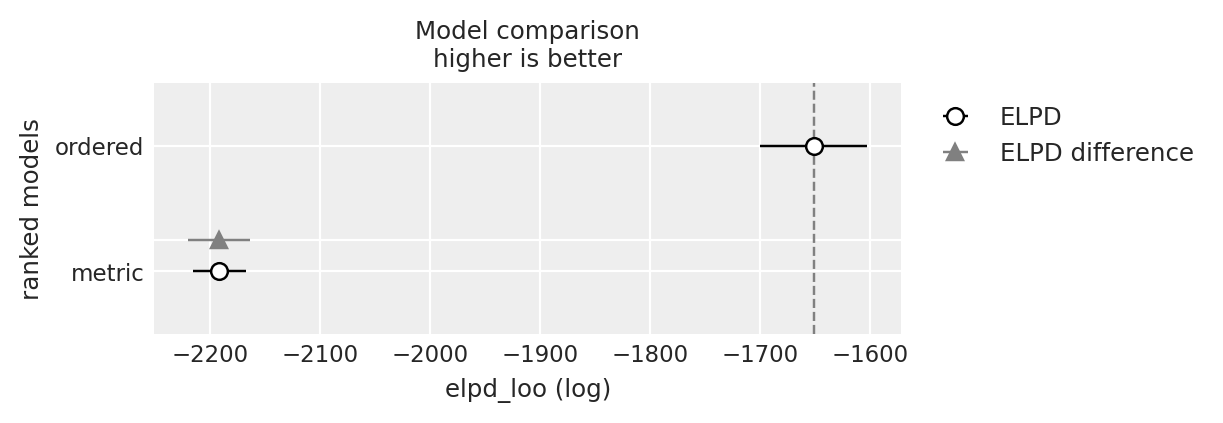

In [33]:
az.plot_compare(y_5_compare)

<Axes: title={'center': 'Model comparison\nhigher is better'}, xlabel='elpd_loo (log)', ylabel='ranked models'>

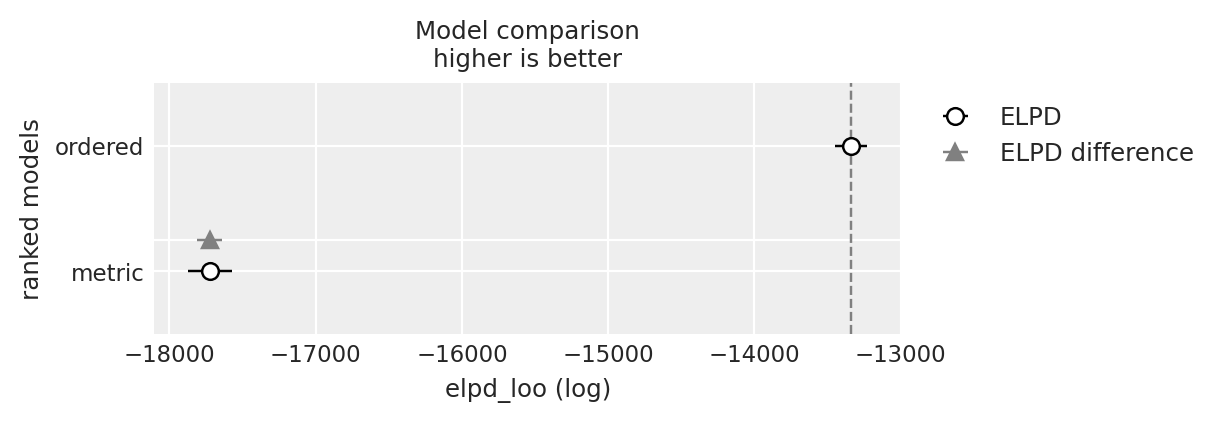

In [34]:
az.plot_compare(y_6_compare)

### Compare Inferences between Models

Aside from the predictive fits, the inference drawns from the different modelling choices also vary quite significantly.

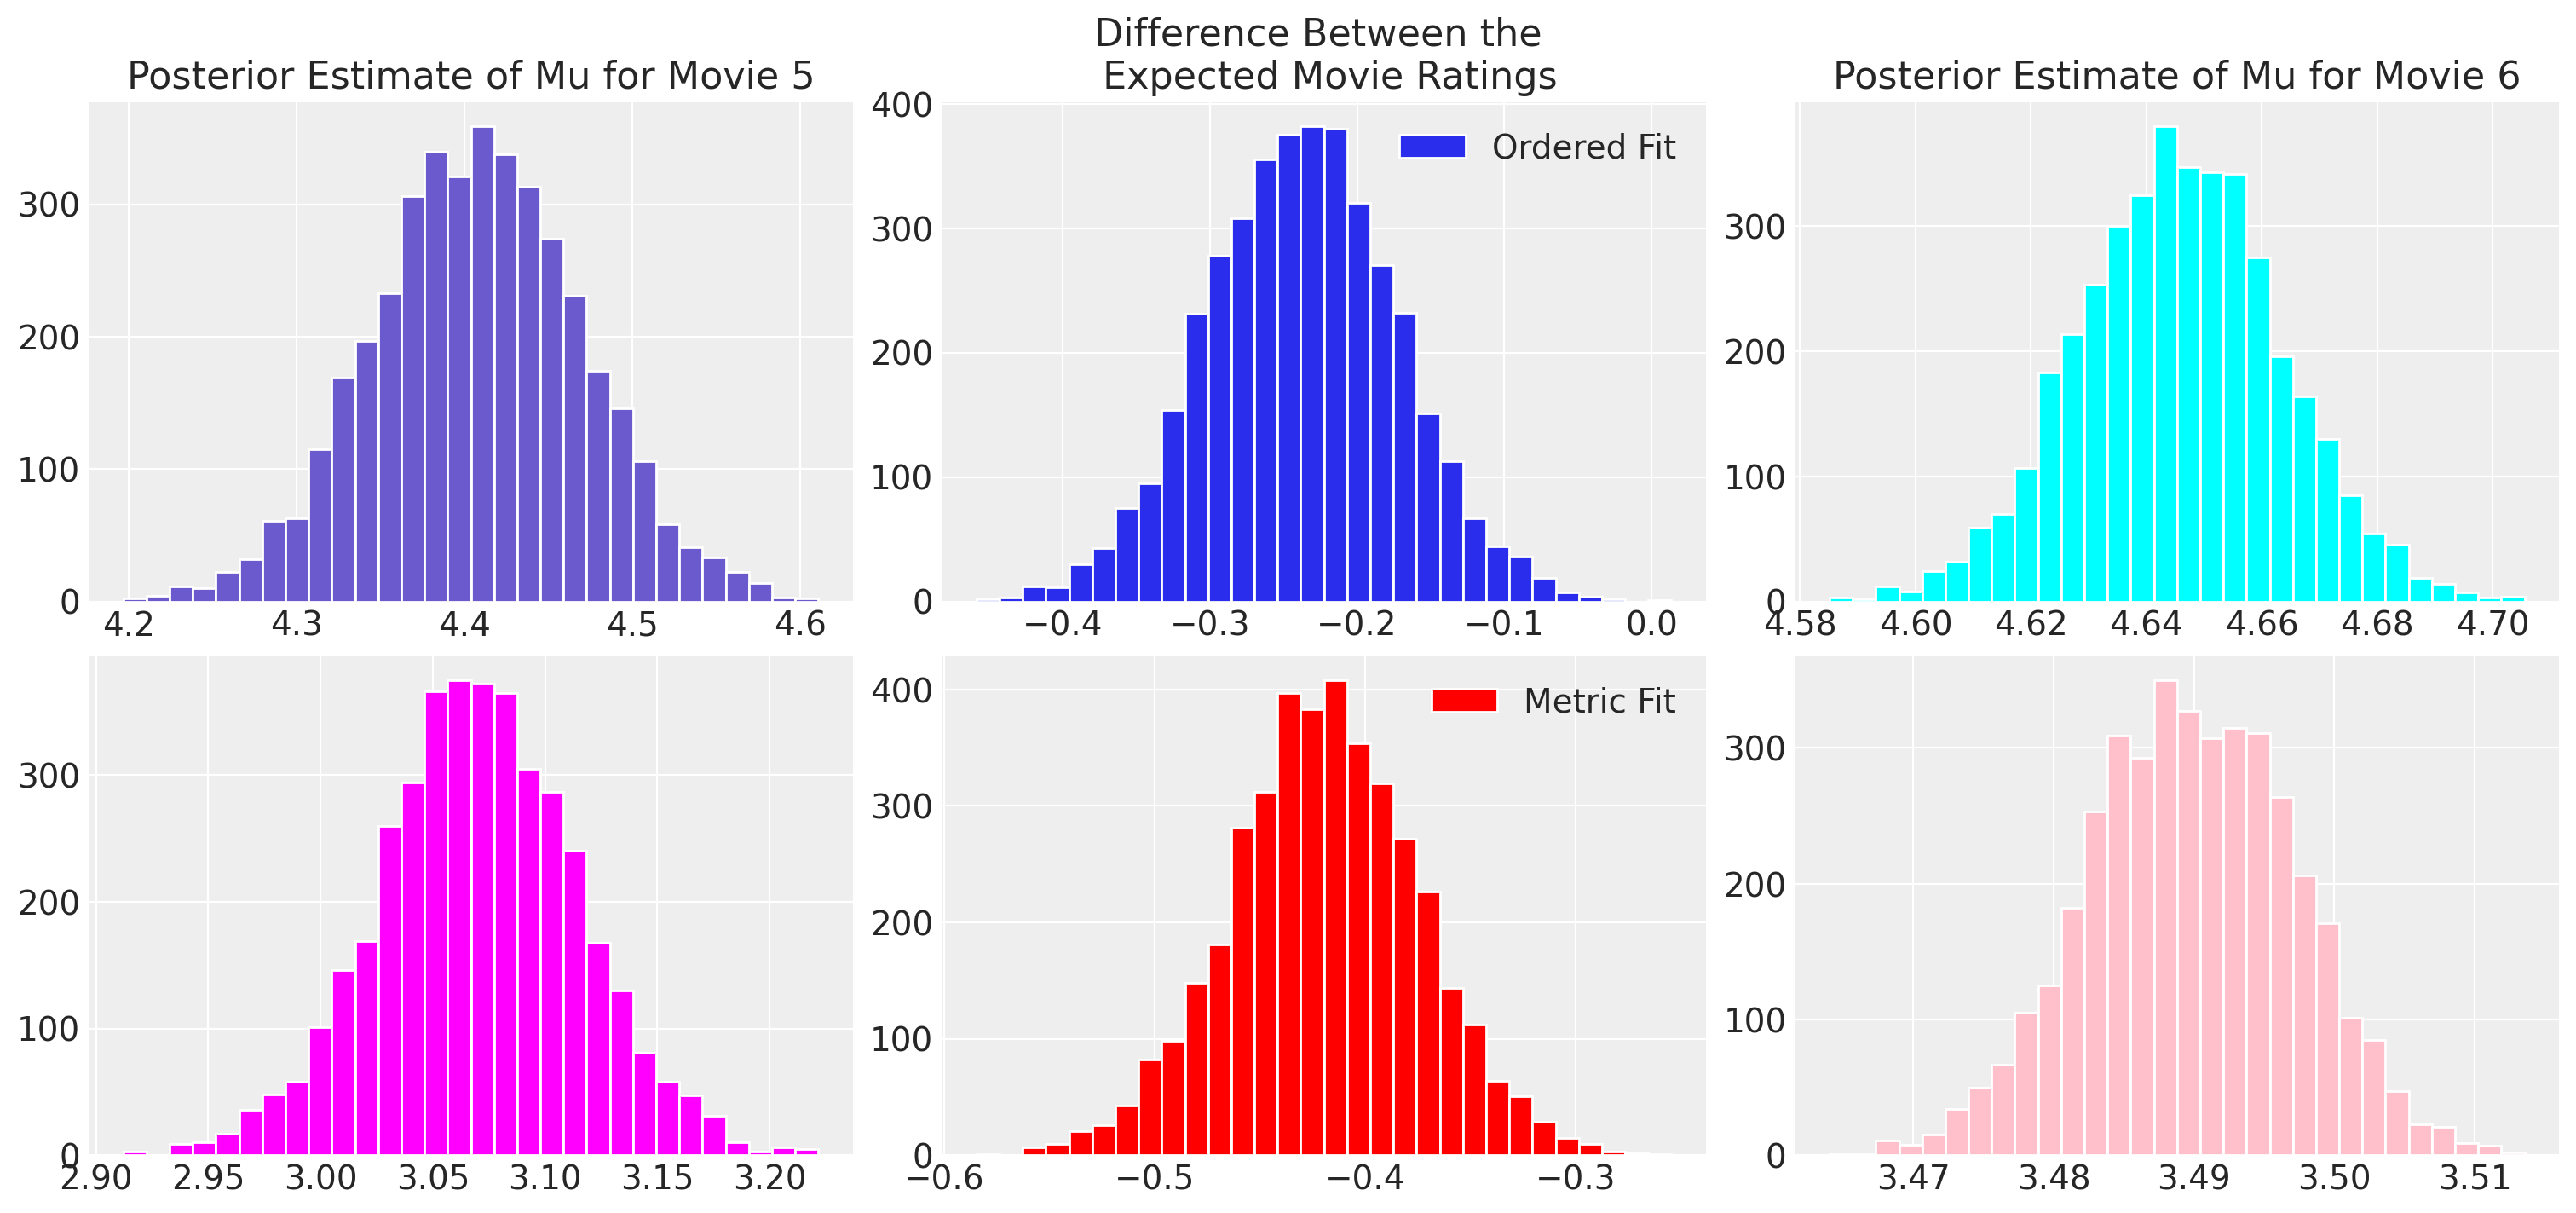

In [35]:
fig, axs = plt.subplots(2, 3, figsize=(15, 7))
axs = axs.flatten()
ordered_5 = az.extract(idata_ordered.posterior)["mu_5"]
ordered_6 = az.extract(idata_ordered.posterior)["mu_6"]
diff = ordered_5 - ordered_6
metric_5 = az.extract(idata_normal_metric.posterior)["mu_5"]
metric_6 = az.extract(idata_normal_metric.posterior)["mu_6"]
diff1 = metric_5 - metric_6
axs[0].hist(ordered_5, bins=30, ec="white", color="slateblue")
axs[1].hist(diff, ec="white", label="Ordered Fit", bins=30)
axs[2].hist(ordered_6, bins=30, ec="white", color="cyan")
axs[3].hist(metric_5, ec="white", bins=30, color="magenta")
axs[4].hist(diff1, ec="white", label="Metric Fit", bins=30, color="red")
axs[5].hist(metric_6, ec="white", bins=30, color="pink")
axs[1].set_title("Difference Between the \n Expected Movie Ratings")
axs[0].set_title("Posterior Estimate of Mu for Movie 5")
axs[2].set_title("Posterior Estimate of Mu for Movie 6")
axs[1].legend()
axs[4].legend();

# Conclusion

In this notebook we've seen how to build ordinal regression models with PyMC and motivated the modelling exercise using the interpretation of ordinal outcomes as the discrete outcomes of a latent continuous phenomena. We've seen how different model specifications can generate more or less interpretable estimates of the parameters underlying the model. We've also compared the ordinal regression approach to a more naive regression approach on ordinal data. The results strongly suggest that the ordinal regression avoids some of the inferential pitfalls that occur with the naive approach. 

## Authors
- Authored by [Nathaniel Forde](https://github.com/NathanielF) in April 2023 

## References
:::{bibliography}
:filter: docname in docnames
:::

## Watermark

In [36]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pytensor

Last updated: Wed Mar 22 2023

Python implementation: CPython
Python version       : 3.11.0
IPython version      : 8.11.0

pytensor: 2.10.1

pandas     : 1.5.3
numpy      : 1.24.2
statsmodels: 0.13.5
pymc       : 5.1.1
arviz      : 0.15.1
pytensor   : 2.10.1
matplotlib : 3.7.1

Watermark: 2.3.1



:::{include} ../page_footer.md
:::